# ETHER / eFEDS data analysis report (LEGACY)

In this Python notebook is all the analysis and work done for the Event Horizon and Environs Sample (ETHER) and the eROSITA Final Equatorial-Depth Survey (eFEDS), including analysis separately and for both catalogues. The order isn't related to that analyzes (ETHER only, eFEDS only, both), so I recommend to read/run this report in order to have a better understanding.

The notebook is prepared for future versions of this catalogues, so it can be runned again in order to obtain new analyzes.

**Disclaimer:** This notebook made use of different methods to analyze (Pandas, Numpy, Scipy, etc.) and visualize (Matplotlib and Seaborn) due to the fact that I was studying by my own, different Data Science courses (Computing Science, Data Analysis and Machine Learning) to broaden my knowledge and hopefully it will be useful for all work hereafter. That's why there are many different packages in this notebook and why I combine these.

In [1]:
import sys
sys.path.insert(0, '../Packages/')

In [2]:
#We start by importing usefull packages for all the analyzes
%matplotlib inline
import numpy as np 
from astropy.io import fits
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from scipy import stats

In [3]:
#ETHER sample (v4 with BCGs)
ethercat = fits.open('../ETHER/ETHER.fits')
#eFEDS sample (Last update of catalogues 02/06/2022)
maincat = fits.open('../eROSITA/eFEDS_c001_main_V7.4.fits')
agncat = fits.open('../eROSITA/eFEDS_AGN_spec_V17.6.fits')
hbcat = fits.open('../eROSITA/eFEDS_c001_hard_V7.4.fits')

In [4]:
ethercat =  ethercat[1].data                    #ETHER catalogue
main_cat = maincat[1].data                      #main catalogue of eFEDS
agn_main = agncat[1].data                       #agn main catalogue of eFEDS
agn_powerlaw = agncat[4].data                   #agn powerlaw fitting of eFEDS
hb_cat = hbcat[1].data                          #hardband selected sources of eFEDS

no_data = 9876543

Now that everything is imported, let's star with the analysis of ETHER.

First a SkyMap to see the regions covered by each of the catalogues

In [5]:
from astropy import units as u

In [6]:
RA_ether = ethercat['RA']*u.degree
DEC_ether = ethercat['DEC']*u.degree

RA1 = main_cat['RA_CORR']*u.degree
DEC1 = main_cat['DEC_CORR']*u.degree

ether_sources = len(RA_ether)
efeds_sources = len(RA1)

percentage = efeds_sources/ether_sources*100

print('Total sources on ETHER: {}'.format(ether_sources))
print('Total sources on eFEDS: {}'.format(efeds_sources))
print('Max percentage of crossmatch: {:.2f}%'.format(percentage))

Total sources on ETHER: 801847
Total sources on eFEDS: 27910
Max percentage of crossmatch: 3.48%


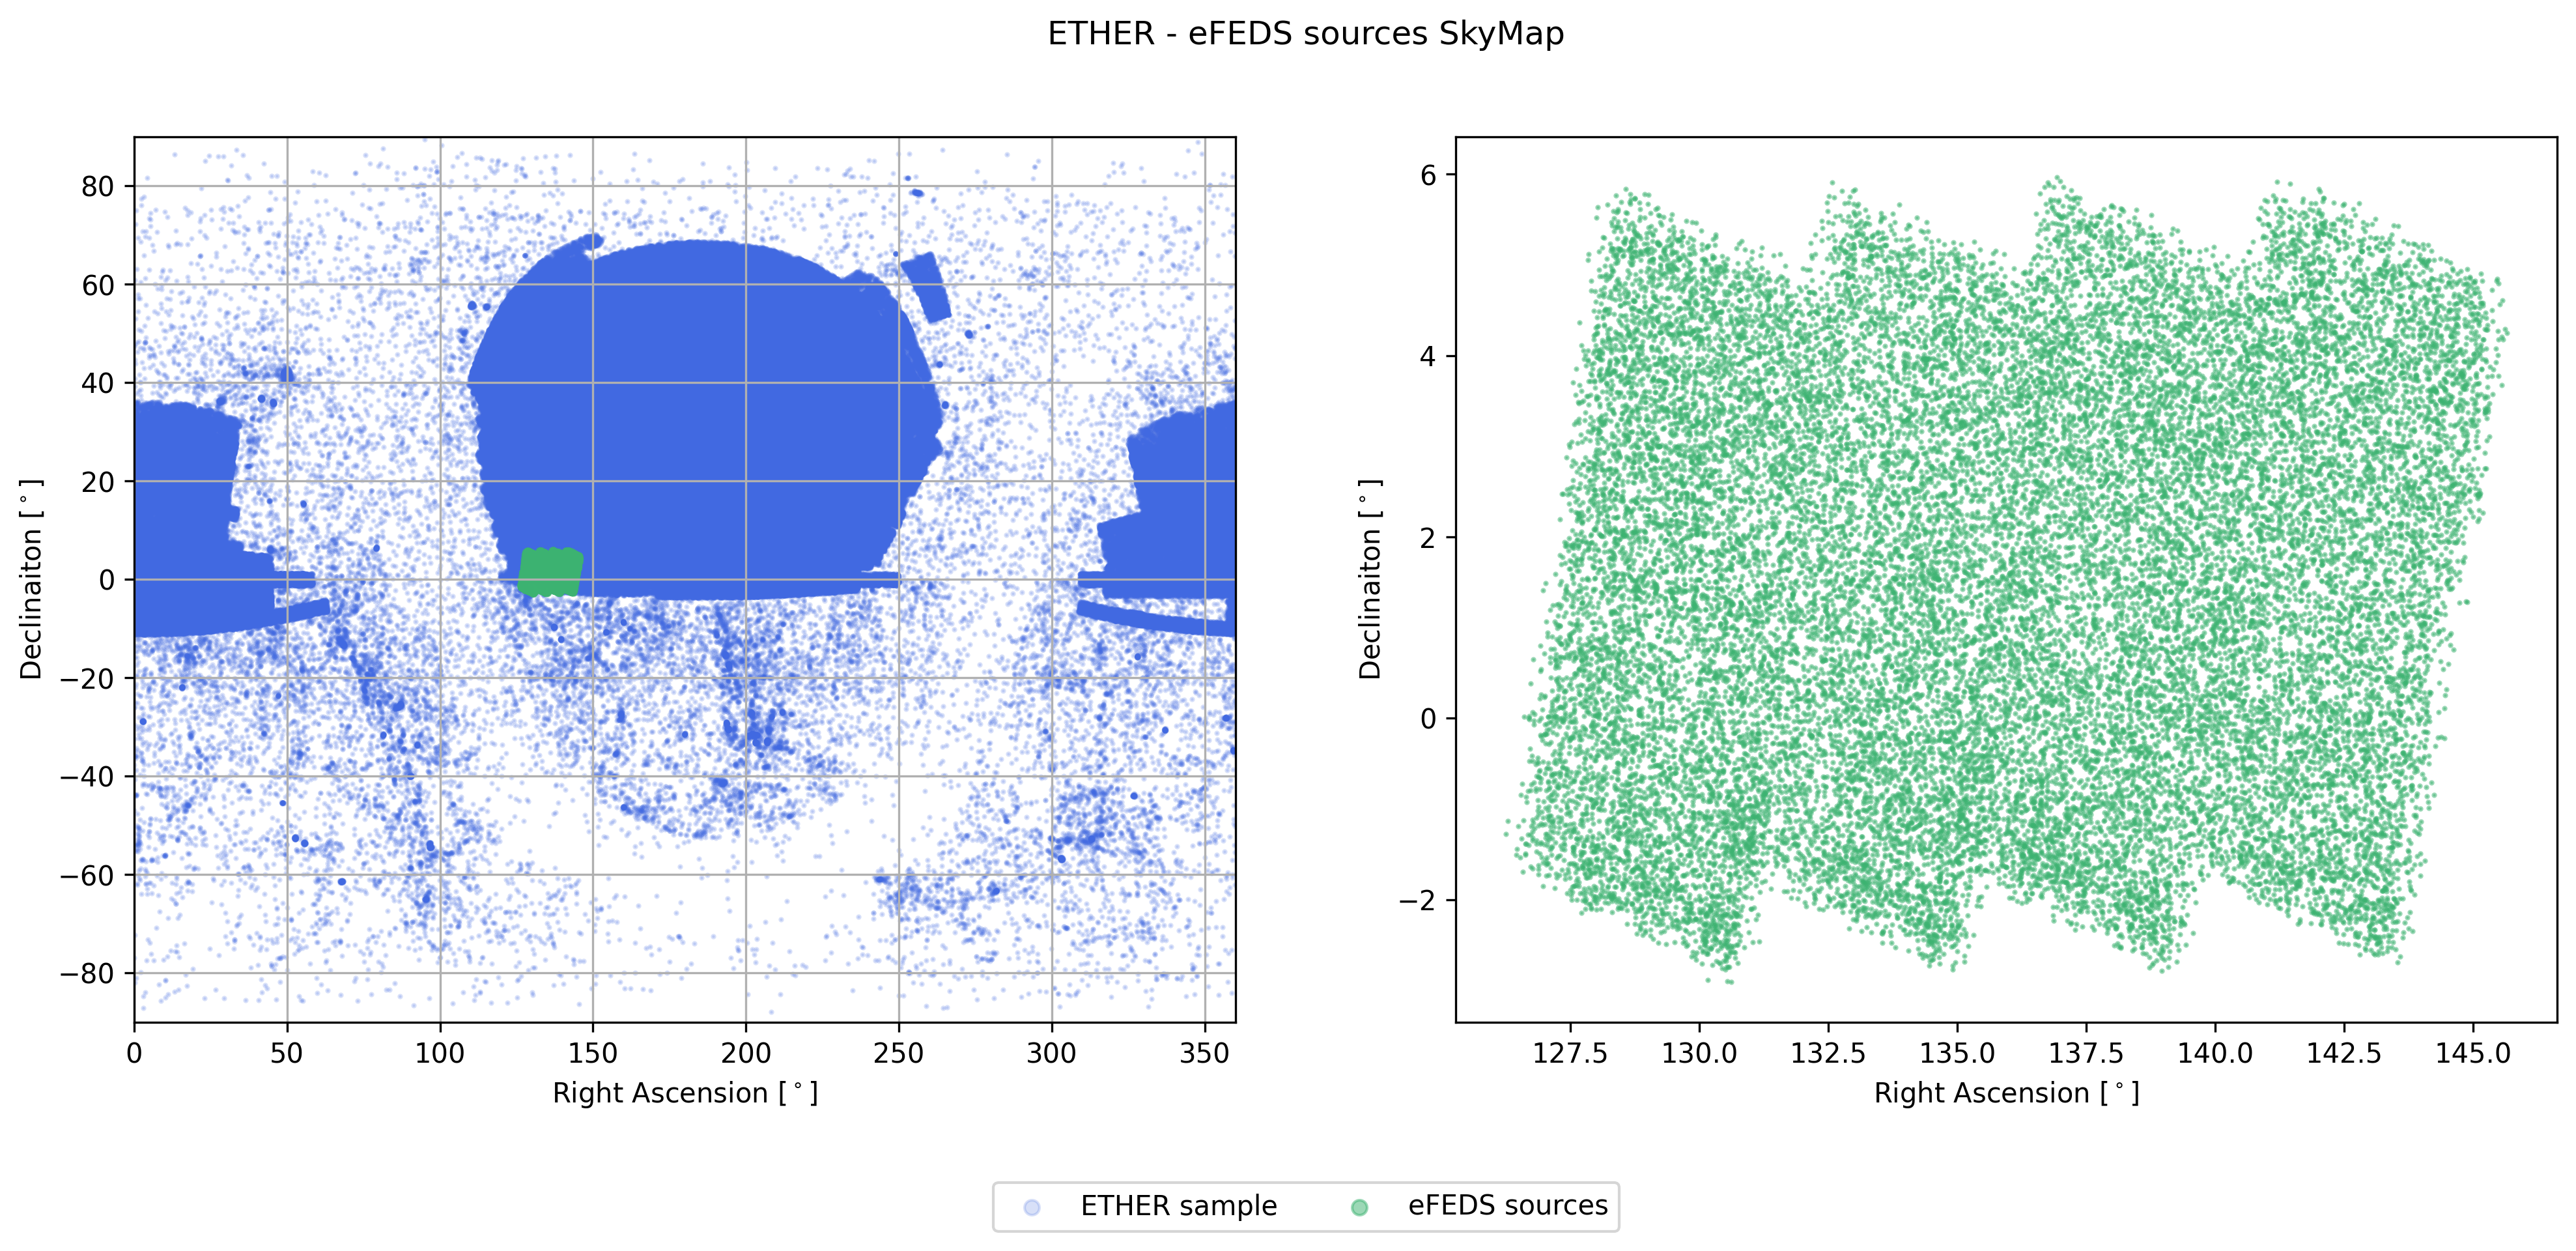

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(16,6))
ax1.grid(True)
ax1.scatter(RA_ether,
    DEC_ether,
    c='royalblue',
    s=1,
    alpha=0.2,
    label='ETHER sample')
ax1.scatter(RA1,
    DEC1,
    c='mediumseagreen',
    s=3,
    alpha=0.5,
    label='eFEDS sources')
ax1.set_xlim(0,360)
ax1.set_ylim(-90,90)
ax1.set_xlabel('Right Ascension [$^\circ$]')
ax1.set_ylabel('Declinaiton [$^\circ$]')

ax2.scatter(RA1,
    DEC1,
    c='mediumseagreen',
    s=1,
    alpha=0.5,
    label='eFEDS sources')
ax2.set_xlabel('Right Ascension [$^\circ$]')
ax2.set_ylabel('Declinaiton [$^\circ$]')

handles, labels = ax1.get_legend_handles_labels()
fig.suptitle('ETHER - eFEDS sources SkyMap')
lgnd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

ETHER covers a huge area in the sky with a more than 500k sources listed, while eFEDS covers a small region of 142 deg$^2$ which contains $\sim$28k sources, representing only a 5.13\% of the ETHER sample, so just a small amount of sources if spected to crossmatch between catalogues.

# ETHER Analysis

In [8]:
z = ethercat['Z']
z = np.delete(z, np.where((z==no_data)|(z<0)))

kde = stats.gaussian_kde(z)
xx = np.linspace(0, max(z), 1000)

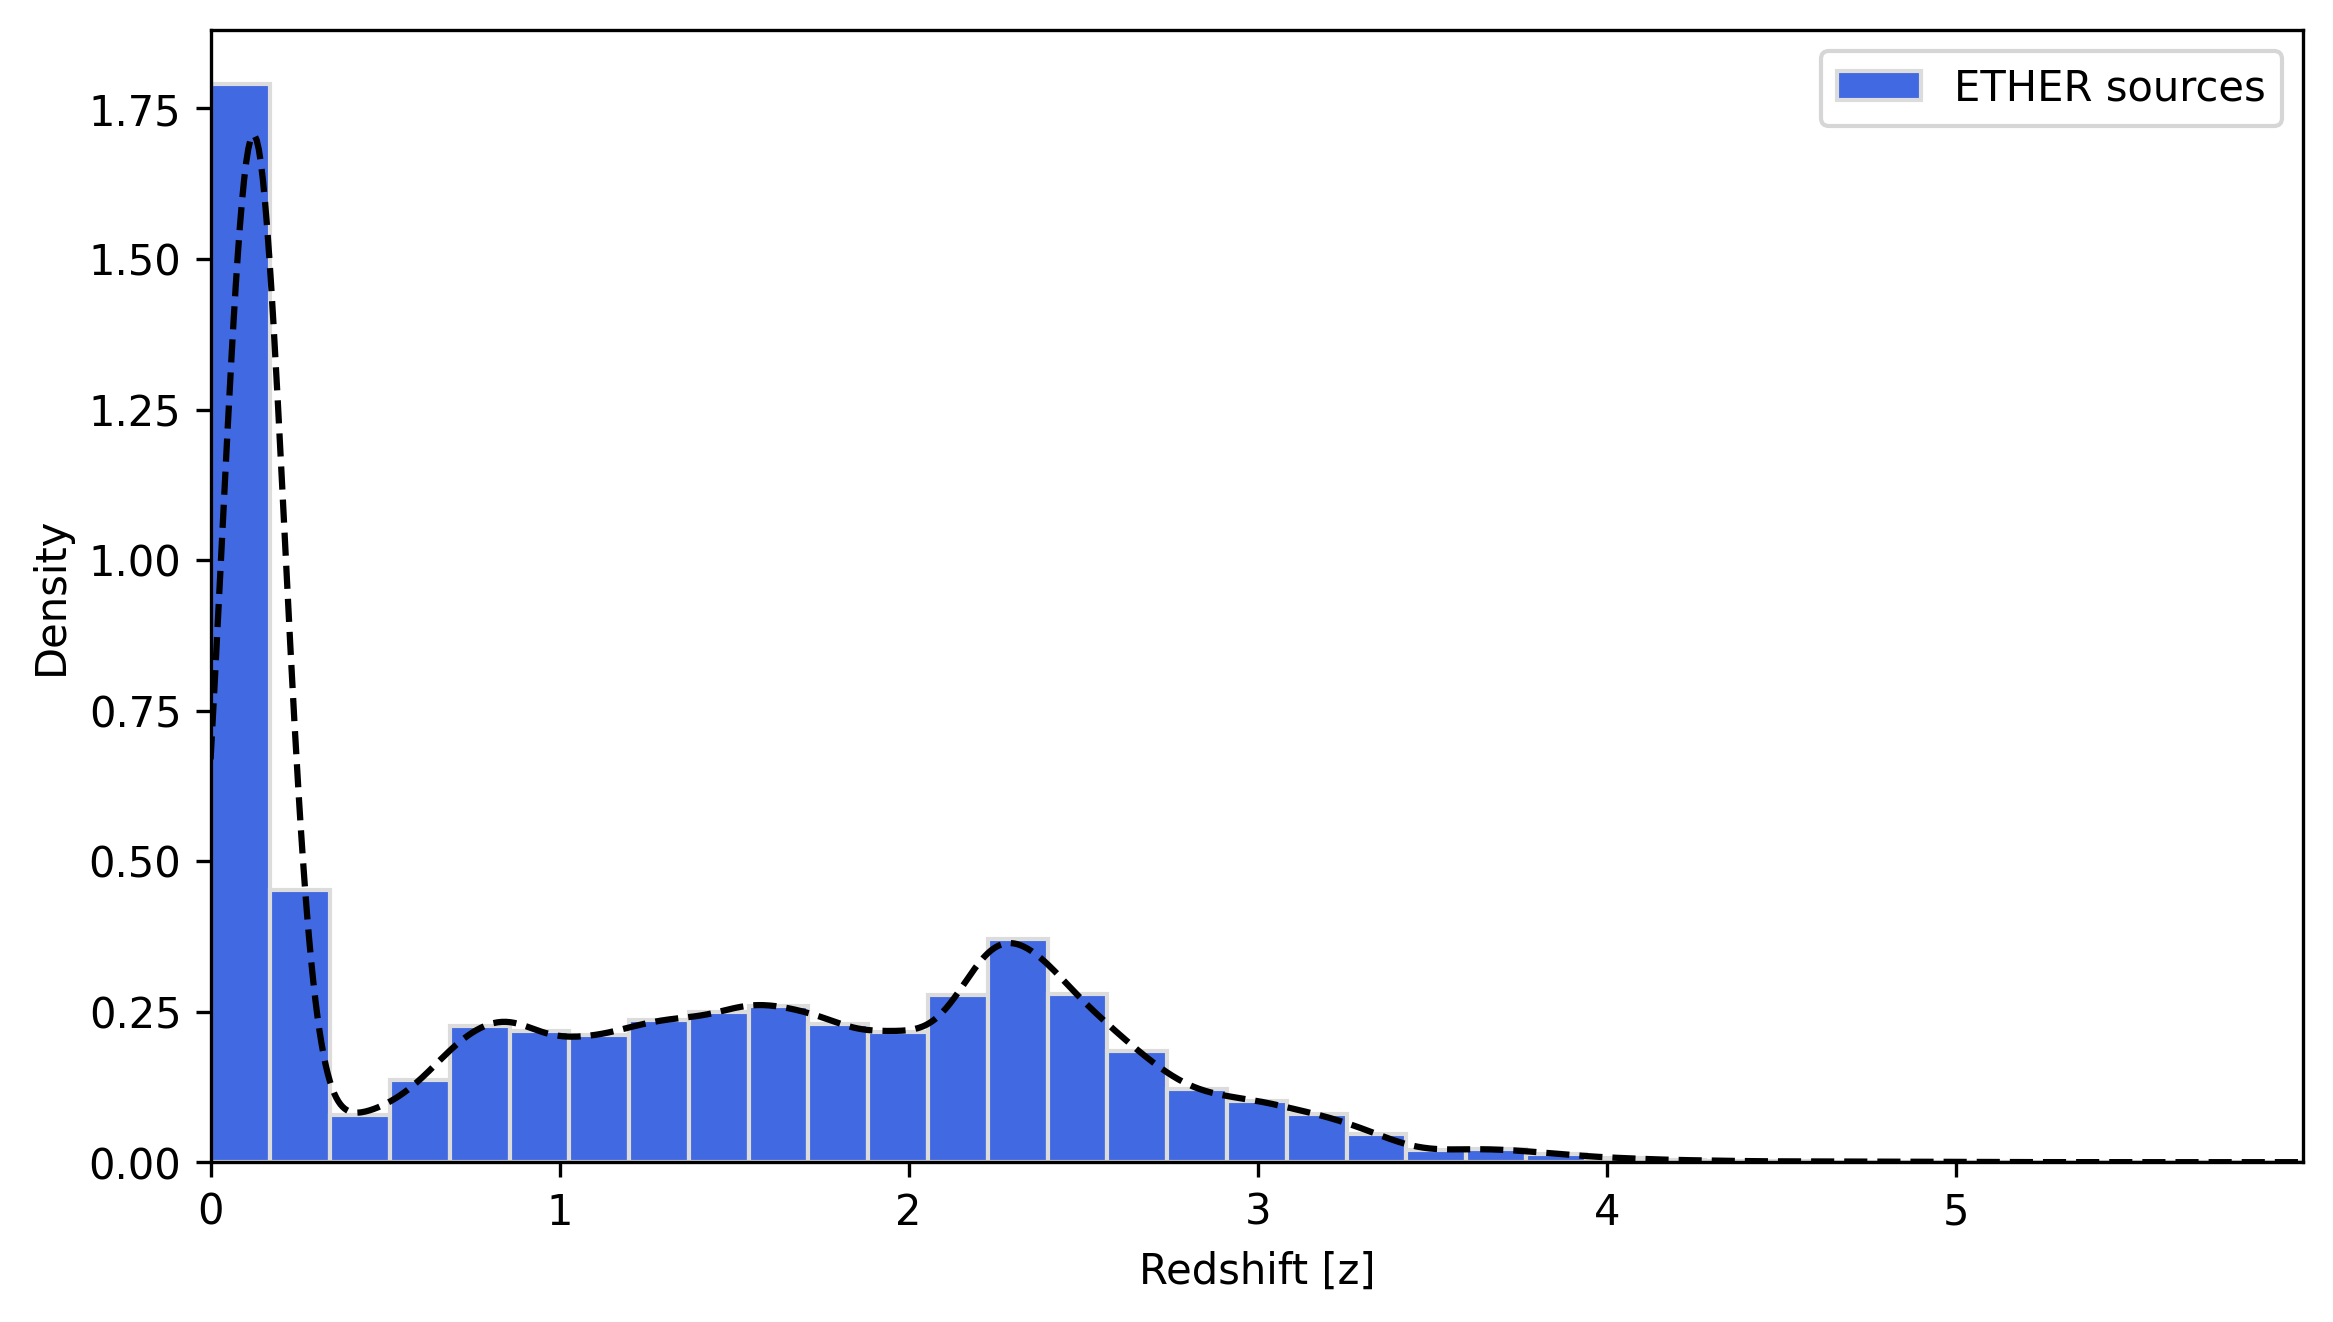

In [9]:
plt.figure(figsize=(9,5), dpi=300)
plt.plot(xx, kde(xx), color='black', linestyle='--')
plt.hist(z,
    bins=35,
    density=True,
    color='royalblue',
    edgecolor='gainsboro',
    label='ETHER sources'
    )
plt.xlabel('Redshift [z]')
plt.ylabel('Density')
plt.margins(x=0)
plt.legend()

In [10]:
close = sum(z<=0.5)/ether_sources*100
bumb = sum((z>=1)*(z<=3))/ether_sources*100

print('Sources closer than z = 0.5: {:.2f}%'.format(close))
print('Sources between z = 1-3: {:.2f}%'.format(bumb))

Sources closer than z = 0.5: 39.21%
Sources between z = 1-3: 46.19%


There are 2 visible overdensities in the histogram, representing AGN closer to us (37.91\%) and a region between z = 1-3 where nearly half of the EHTER catalogue is located (49.01\%). Despite that, we must consider the angular diameter increase by redshift (which for $\Lambda$CDM model reaches it's maximum at z $\sim$ 1.5) to image sources, so the ones between those overdensities are still relevant.

ETHER catalogue also deliver different measurements/estimations for the black hole mass (MBH) and its methods (MBHSOURCE). This methods are specified in a numerical way, instead of a categorical, but the meaning of each code is in the **addgal1.pro** file provided with the ETHER fits file.

Single Epoch RM    489859
M-Sigma            293973
M-Bulge              4688
Blazar Comp.          570
Measured              199
Optical Lum.           58
FP-Sigma               37
HU Measured            23
Name: Method, dtype: int64


Text(9.924999999999997, 0.5, 'log $M_{BH}$ [$M_\\odot$]')

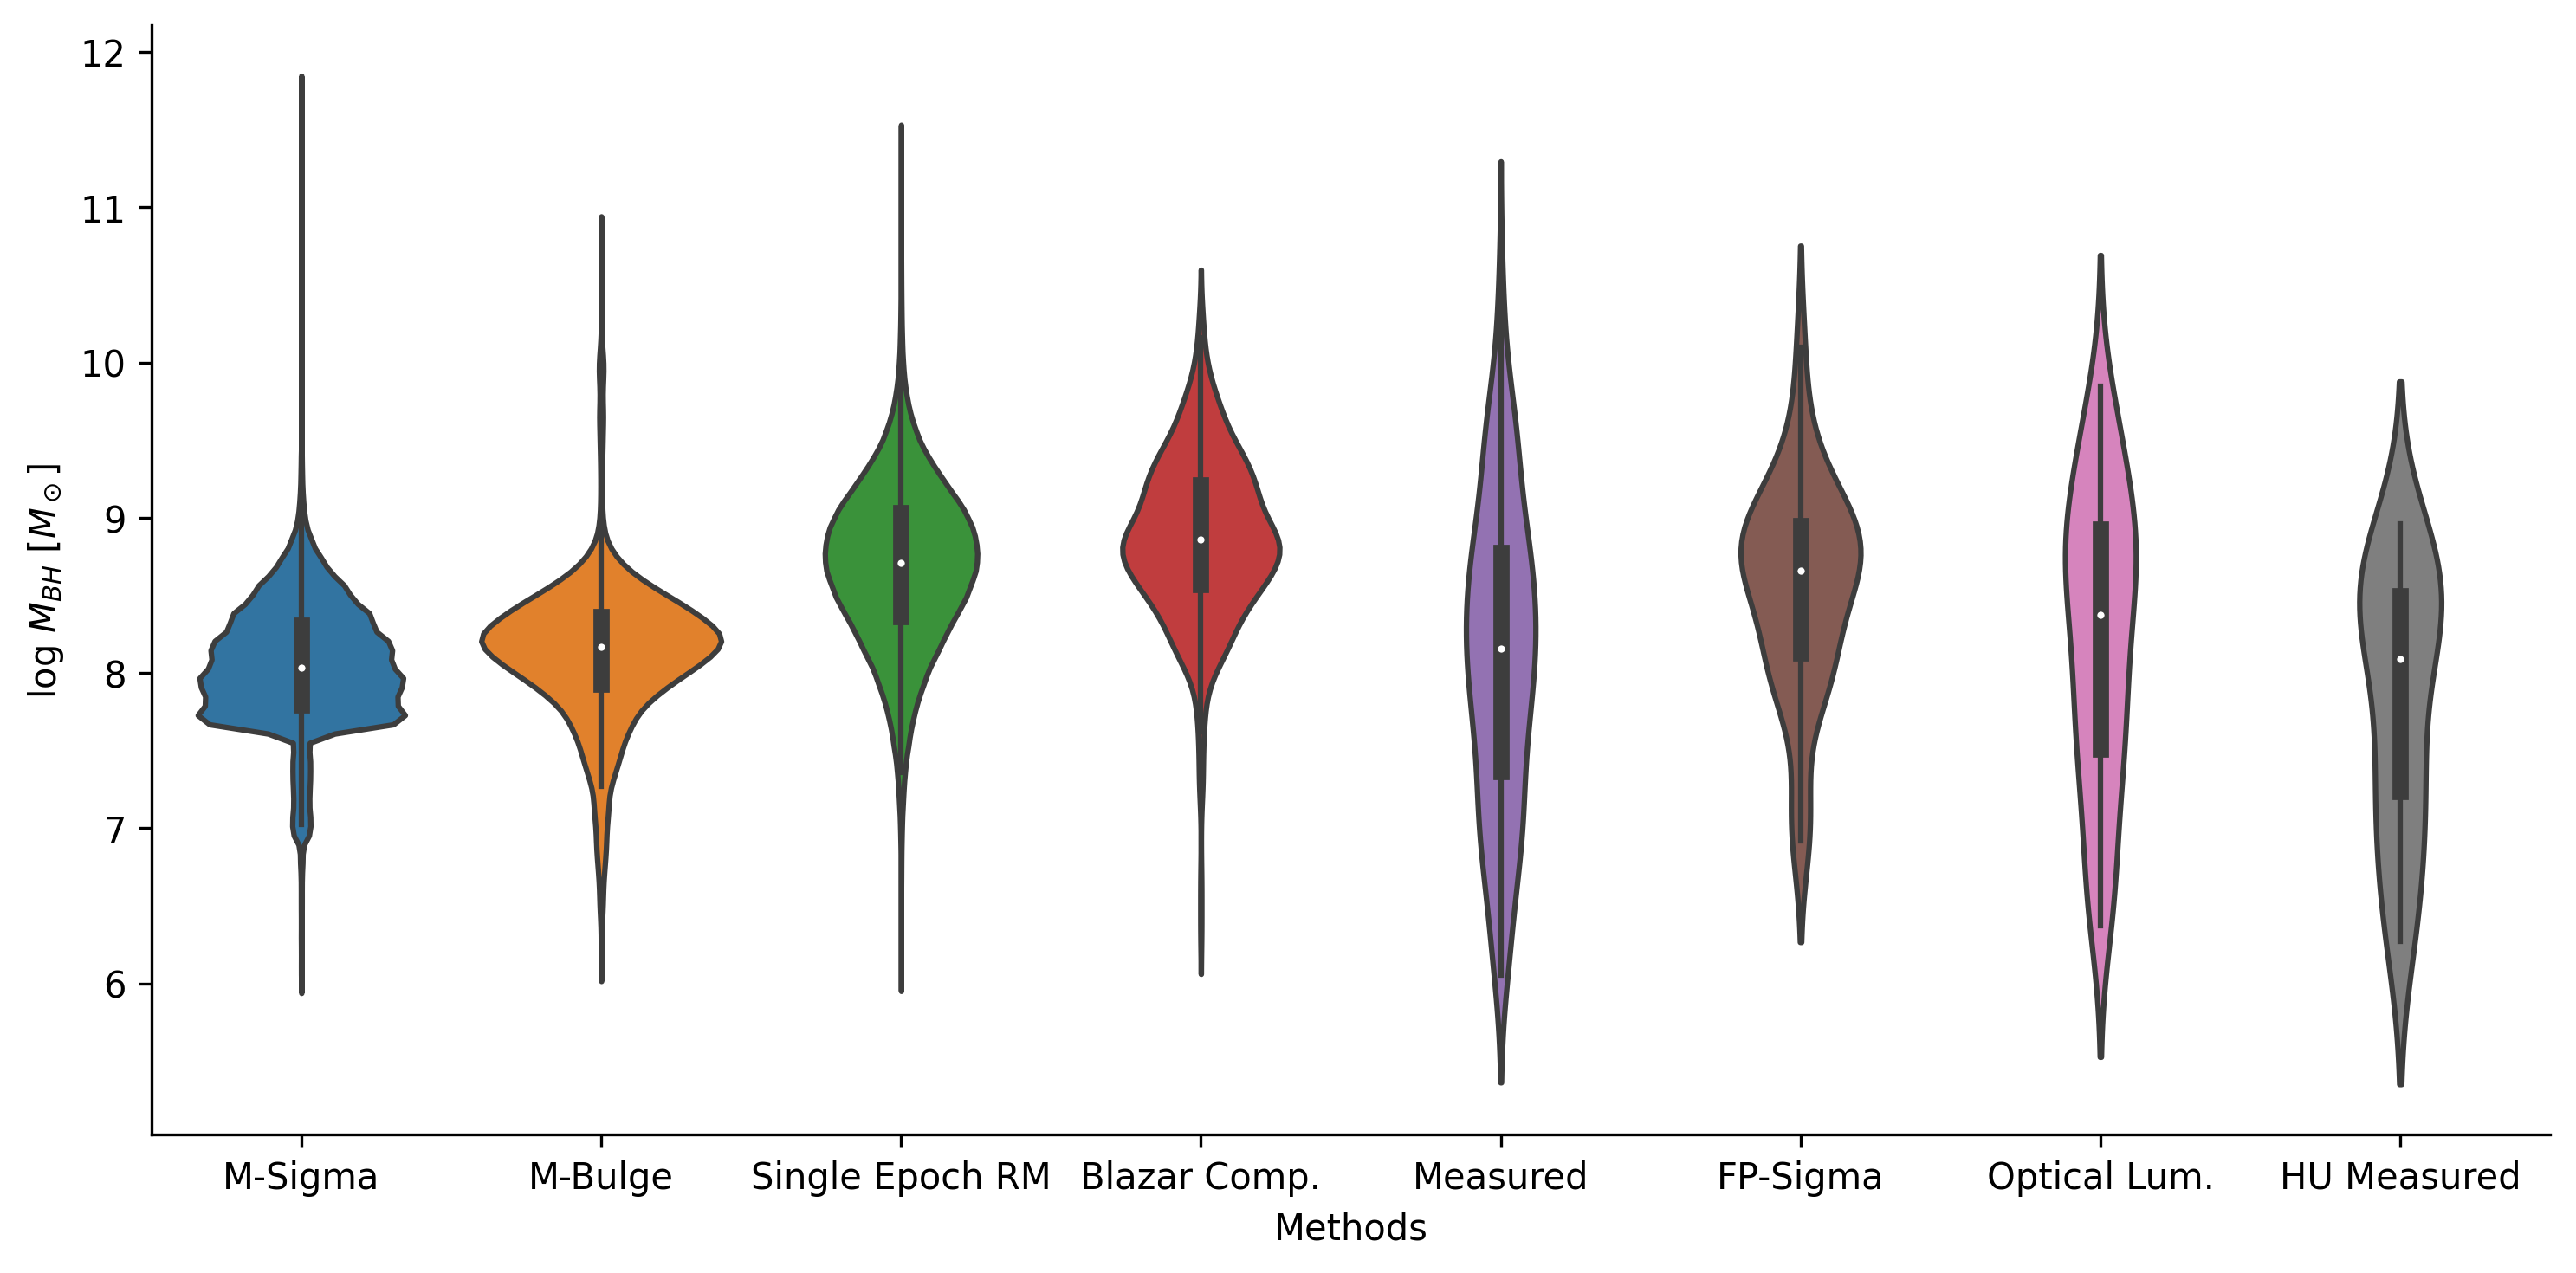

In [11]:
methods = ['Measured','HU Measured','M-Sigma','M-Bulge','Single Epoch RM','Optical Lum.','FP-Sigma','Blazar Comp.']
codes = [0,'0.5','1.0','2.0','3.0','4.0','5.0','6.0']

mbh = ethercat['MBH']
mbhsource = ethercat['MBHSOURCE']
mbh_filt = np.delete(mbh, np.where(mbhsource==no_data))
mbhsource_filt = np.delete(mbhsource, np.where(mbhsource==no_data))

for code in codes:
    index = codes.index(code)
    mbhsource_filt = np.where(mbhsource_filt==code, methods[index], mbhsource_filt)

stacked = np.column_stack((mbh_filt,mbhsource_filt))
df = pd.DataFrame(stacked, columns=['Mbh','Method'])
print(df['Method'].value_counts())

df_copy = df.copy()
df_copy = df_copy.explode('Mbh')
df_copy['Mbh'] = df_copy['Mbh'].astype('float')

g = sns.catplot(x='Method', y='Mbh', kind='violin', data=df_copy, height=5, aspect=2)
g.fig.set_dpi(300)
plt.xlabel('Methods')
plt.ylabel(r'log $M_{BH}$ [$M_\odot$]')

In [12]:
percentage_sd = len(df[(df.Method=='Measured')|(df.Method=='HU Measured')|(df.Method=='Optical Lum.')|(df.Method=='FP-Sigma')])/len(df['Method'])*100
percentage_cd = len(df[(df.Method=='M-Sigma')|(df.Method=='Blazar Comp.')|(df.Method=='Single Epoch RM')|(df.Method=='M-Bulge')])/len(df['Method'])*100

print('Percentage smooth distribution: {:.2f}%'.format(percentage_sd))
print('Percentage clustered distribution: {:.2f}%'.format(percentage_cd))

Percentage smooth distribution: 0.04%
Percentage clustered distribution: 99.96%


Measured, Higlhy Uncertain (HU) measured, Optical Lum. ans FP-Sigma methods present **well distributed sources** (smooth distributions) but represent a **small percentage of the whole sample** (less than 1\%), while M-Sigma, Blazar Comp, Single Epoch RM and M-Bulge present **clustered distributions and are the majority of the sample** (99\%). This last methods will bias any relation or estimation due to that concentration on bounded values of masses, while the well distributed methods will provide masses on the whole range of super massive black holes (SMBH, 6-10), but will have low statistical significance due to the small amount of sources, compared to the total. Some masses are over 10, which is bordering theoretical limits to Mbh on SMBH, and others are below 6, which enters in the intermediate mass black hole (IMBH, 2-6) regime.

ETHER catalgue also contains mesurements of radio in different bands (in GHz) for many of its sources. This measurement is crucial in order to model the ADAF and jet emission of the AGN.

In [13]:
freqvec=['1.4','2.2','4.8','8.6','15','23','45','86','230','345']
radio1 = ethercat['FLUX1']
radio1id = [freqvec[0]]*len(radio1)
radio2 = ethercat['FLUX2']
radio2id = [freqvec[1]]*len(radio2)
radio5 = ethercat['FLUX5']
radio5id = [freqvec[2]]*len(radio5)
radio8 = ethercat['FLUX8']
radio8id = [freqvec[3]]*len(radio8)
radio15 = ethercat['FLUX15']
radio15id = [freqvec[4]]*len(radio15)    #here I'd had to format the data manually, this was a pain
radio23 = ethercat['FLUX23']
radio23id = [freqvec[5]]*len(radio23)
radio43 = ethercat['FLUX43']
radio43id = [freqvec[6]]*len(radio43)
radio86 = ethercat['FLUX86']
radio86id = [freqvec[7]]*len(radio86)
radio230 = ethercat['FLUX230']
radio230id = [freqvec[8]]*len(radio230)
radio345 = ethercat['FLUX345']
radio345id = [freqvec[9]]*len(radio345)
radio_data = np.column_stack((radio1,radio2,radio5,radio8,radio15,radio23,radio43,radio86,radio230,radio345))

data_conc = np.concatenate((radio1,radio2,radio5,radio8,radio15,radio23,radio43,radio86,radio230,radio345), axis=None)
id_conc = np.concatenate((radio1id,radio2id,radio5id,radio8id,radio15id,radio23id,radio43id,radio86id,radio230id,radio345id), axis=None)
radio_melt = np.column_stack((id_conc, data_conc))


In [14]:
df = pd.DataFrame(radio_data, columns=freqvec)
print((df!=no_data).sum(axis=0))
df_melt = pd.DataFrame(radio_melt, columns=['GHz', 'Value'])
df_melt['Value'] = df_melt['Value'].astype('float')
df_melt = df_melt[df_melt!=no_data]

1.4    36941
2.2     5126
4.8    15037
8.6    13969
15      1250
23      1100
45       200
86      2975
230     2132
345     1375
dtype: int64


The catalogue contain more than 12k measurements in both the 8.6 and 4.8 GHz band, which represent the emission that best characterize the ADAF, so this information is of great importance.

Text(-15.075000000000003, 0.5, 'Flux [mJy]')

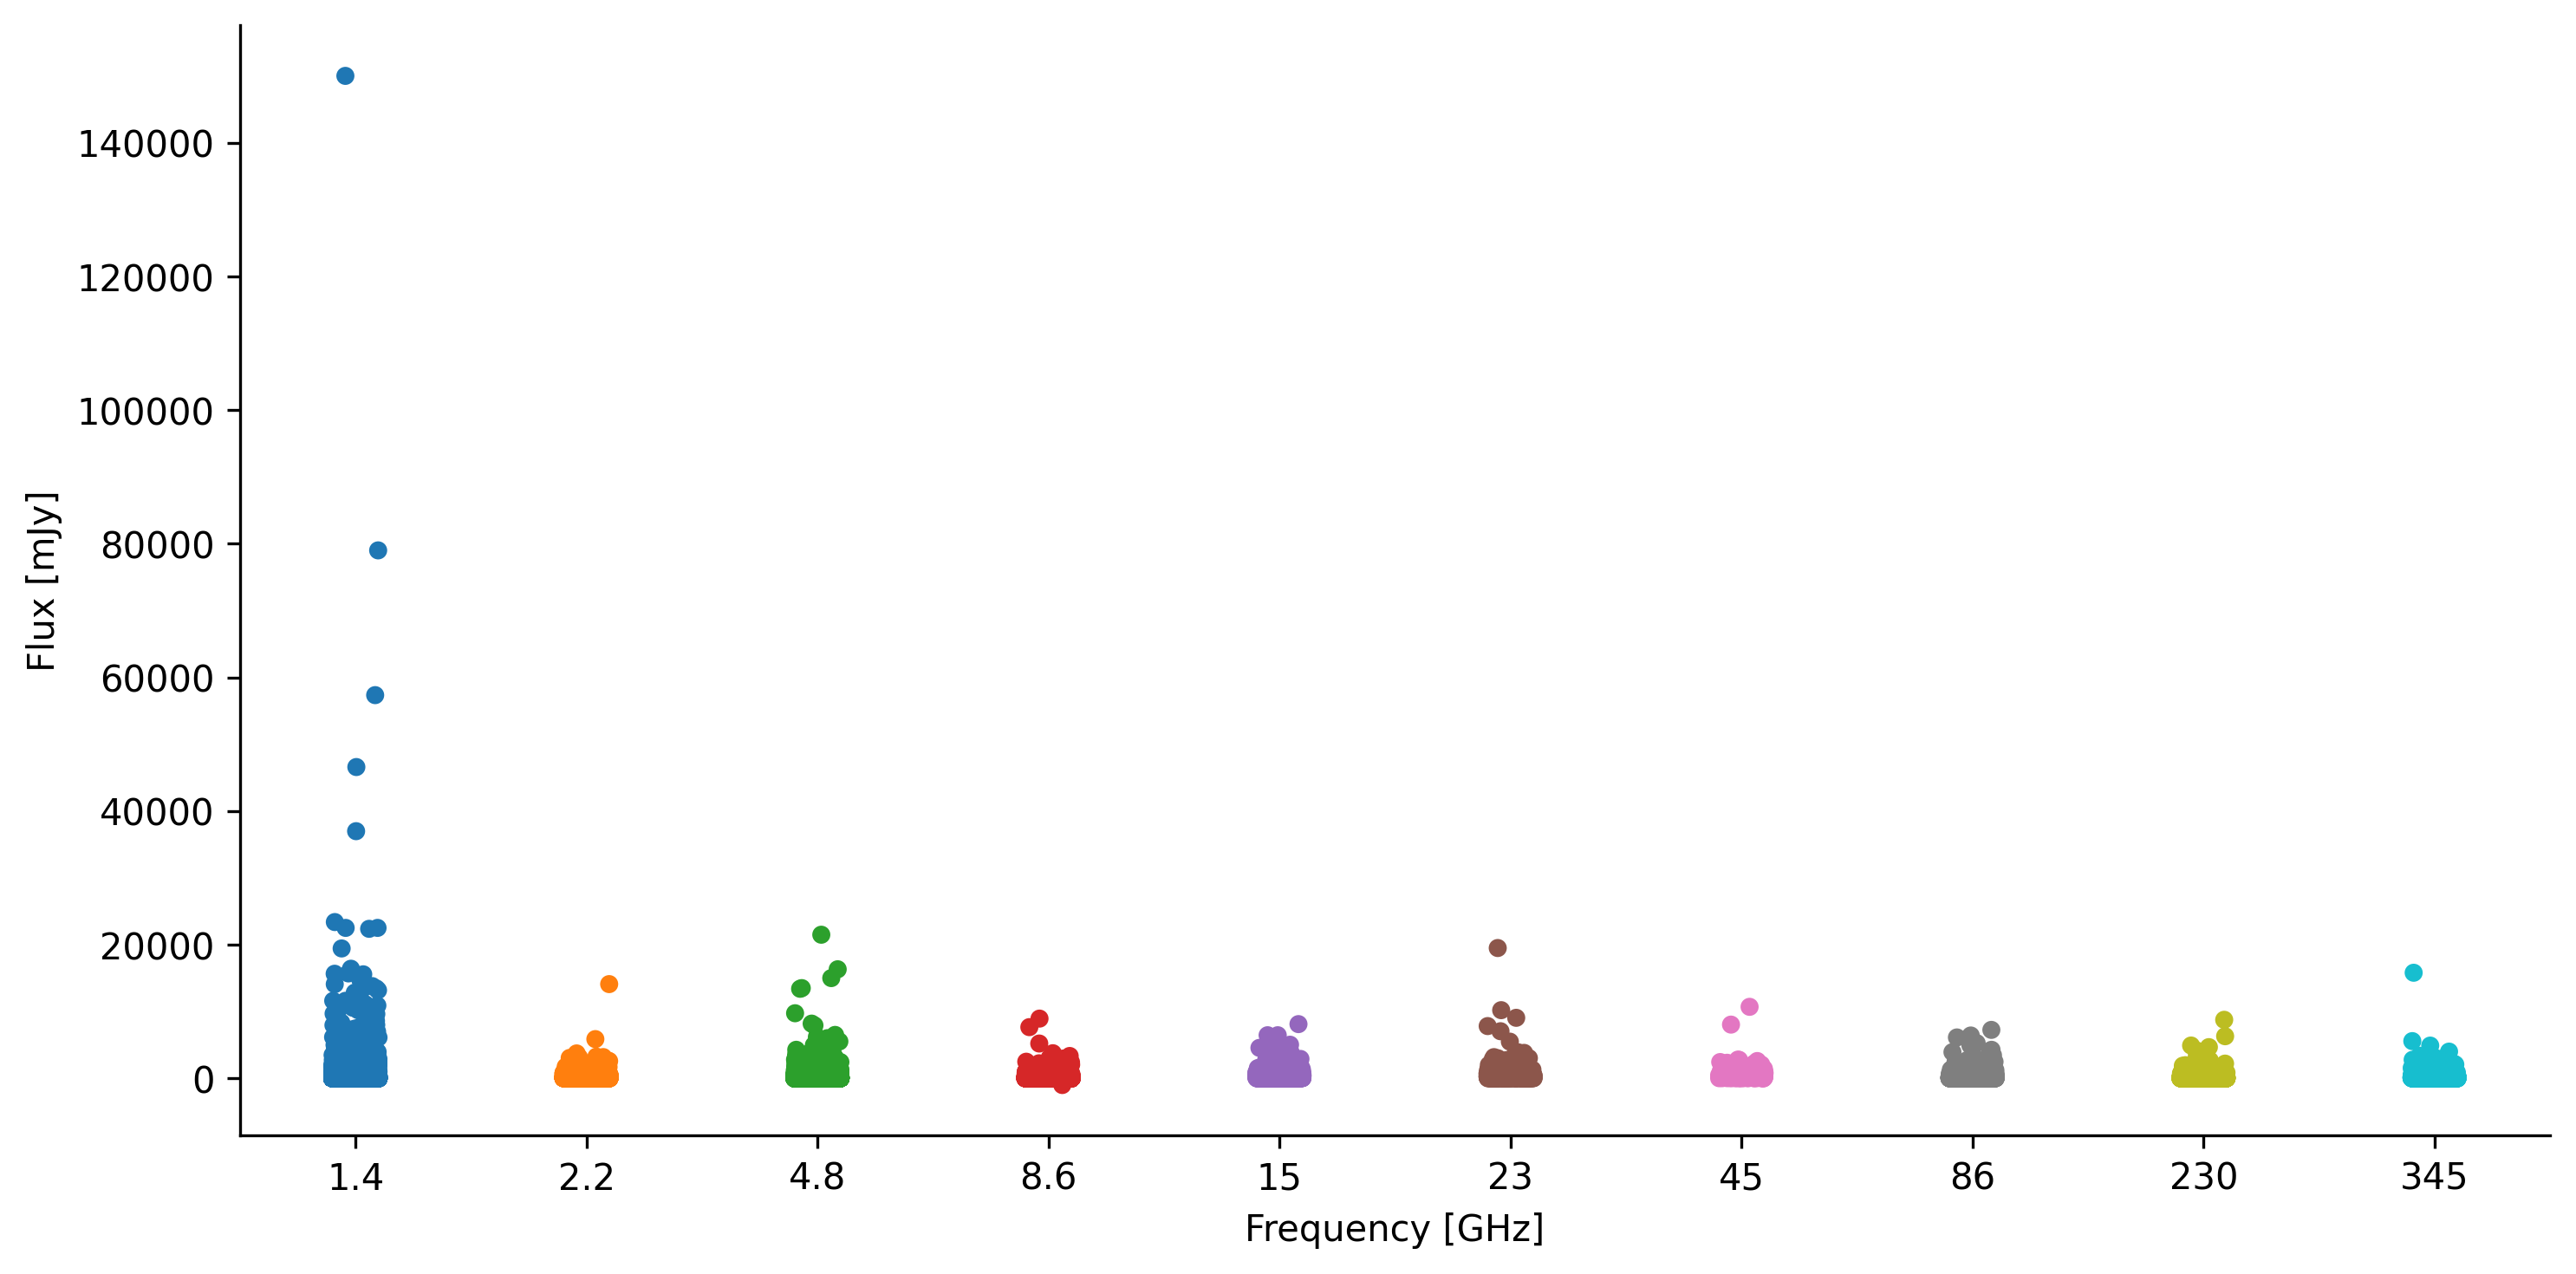

In [15]:
g = sns.catplot(x='GHz', y='Value', data=df_melt, height=5, aspect=2)
g.fig.set_dpi(300)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Flux [mJy]')

We can clearly see that there're incredibly higher values (respect to the median), so I'll leave them out to see just the distribution of low values, since I don't know the origin of this data or if their units of measure are well marked.

Text(0, 0.5, 'Flux [mJy]')

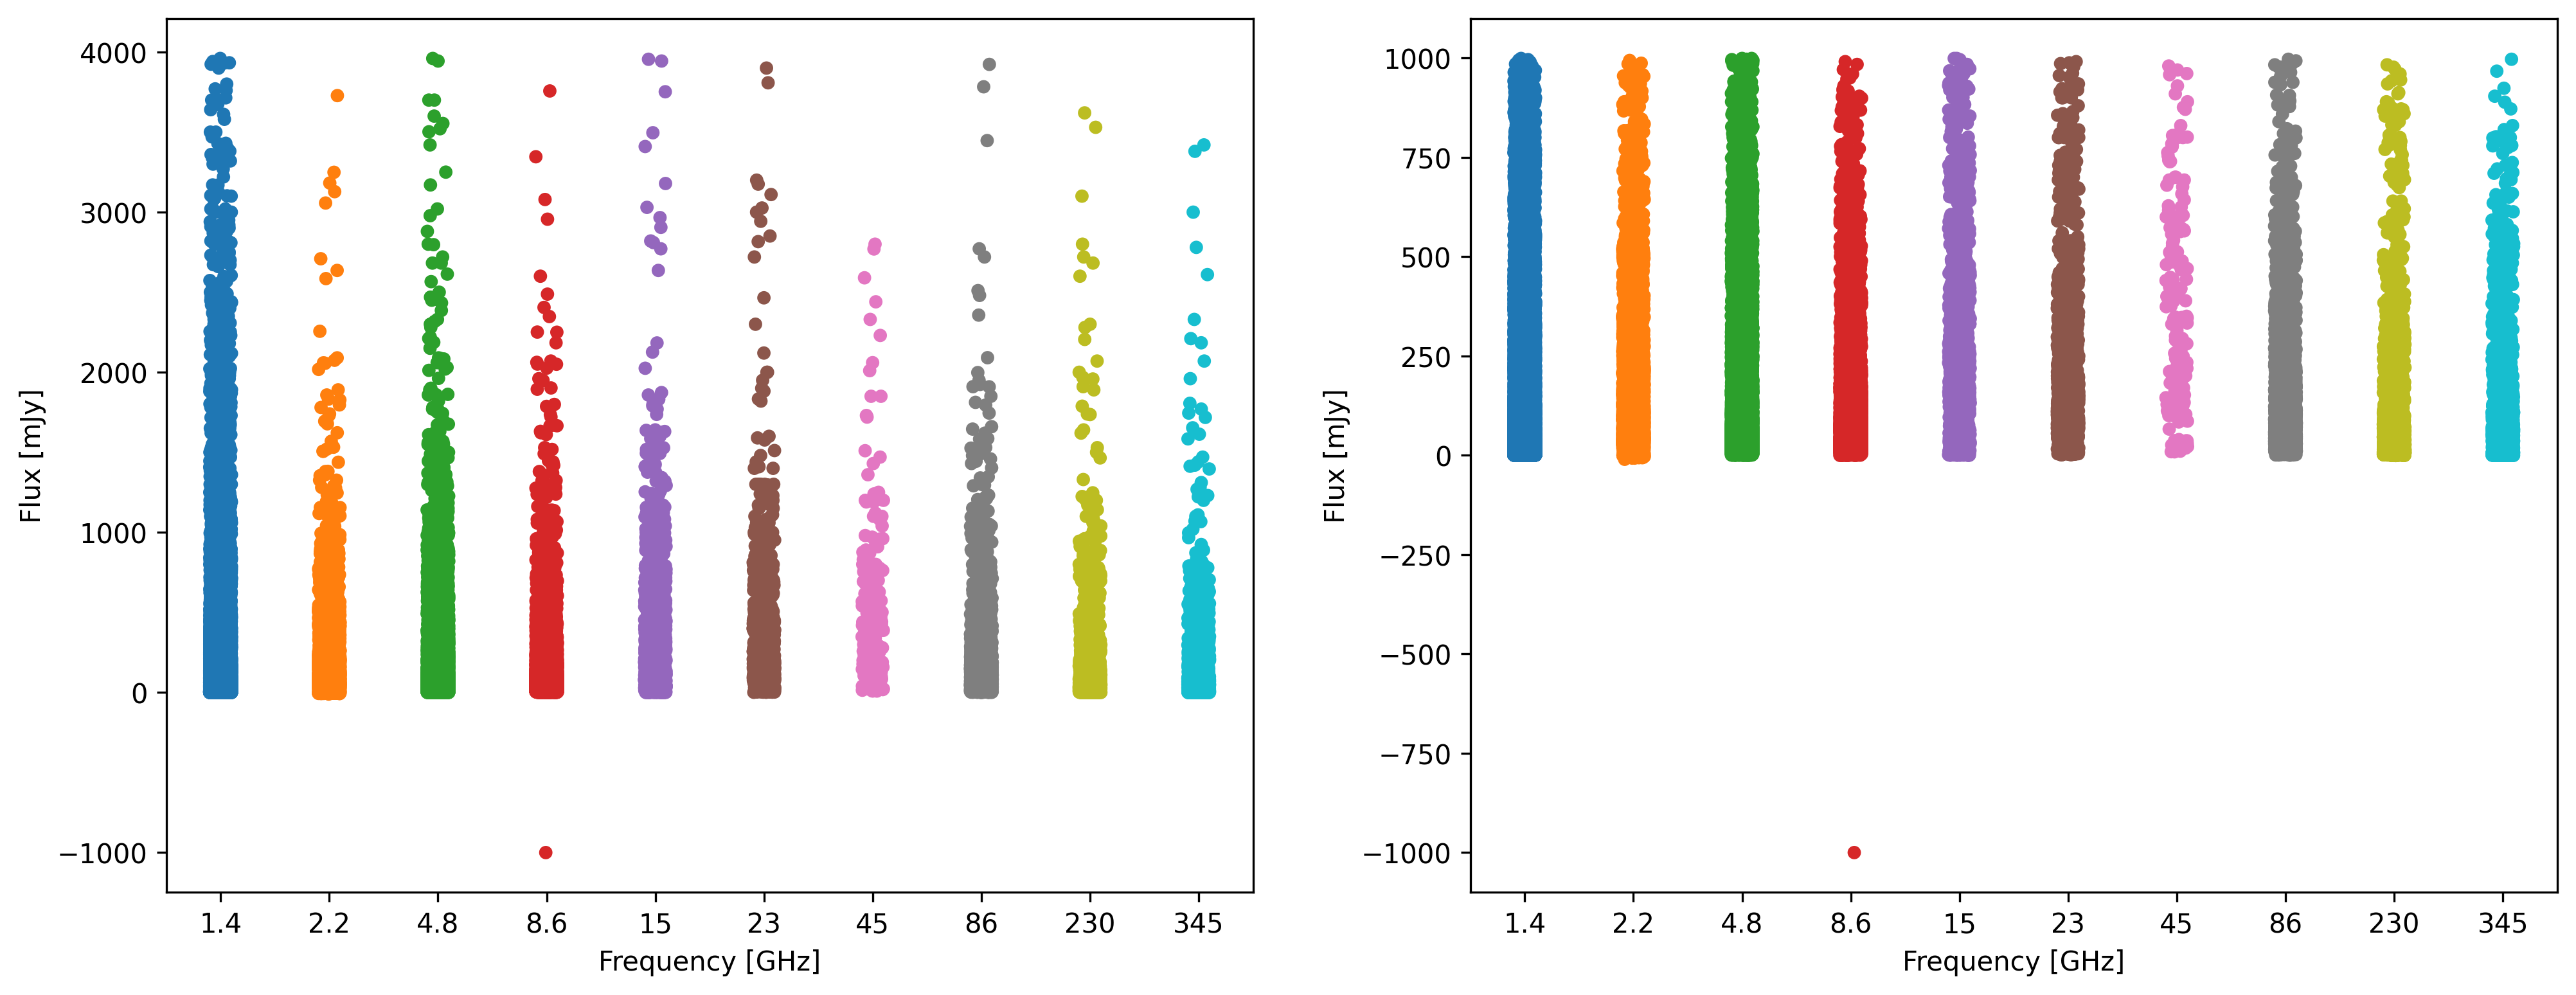

In [16]:
fig, axs = plt.subplots(1,2, figsize=(16,6), dpi=300)

df_melt2 = df_melt[df_melt['Value']<4000]
sns.stripplot(x='GHz', y='Value', data=df_melt2, ax=axs[0])
# sns.violinplot(x='GHz', y='Value', data=df_melt2, inner=None, color='.8', ax=axs[0])

df_melt3 = df_melt[df_melt['Value']<1000]
sns.stripplot(x='GHz', y='Value', data=df_melt3, ax=axs[1])
# sns.violinplot(x='GHz', y='Value', data=df_melt3, inner=None, color='.8', ax=axs[1])

axs[0].set_xlabel('Frequency [GHz]')
axs[1].set_xlabel('Frequency [GHz]')
axs[0].set_ylabel('Flux [mJy]')
axs[1].set_ylabel('Flux [mJy]')

With this 2 bounded plots it's clear that most of the data point are, in fact, below 1000 mJy. Important to consider this for posteriori analyzes or use of this data.

Sources without any measurement: 761156
Percentage of source without measurements: 94.93%


1     24167
3      6839
2      4849
4      1949
5      1121
6       764
7       525
8       283
9       141
10       53
dtype: int64

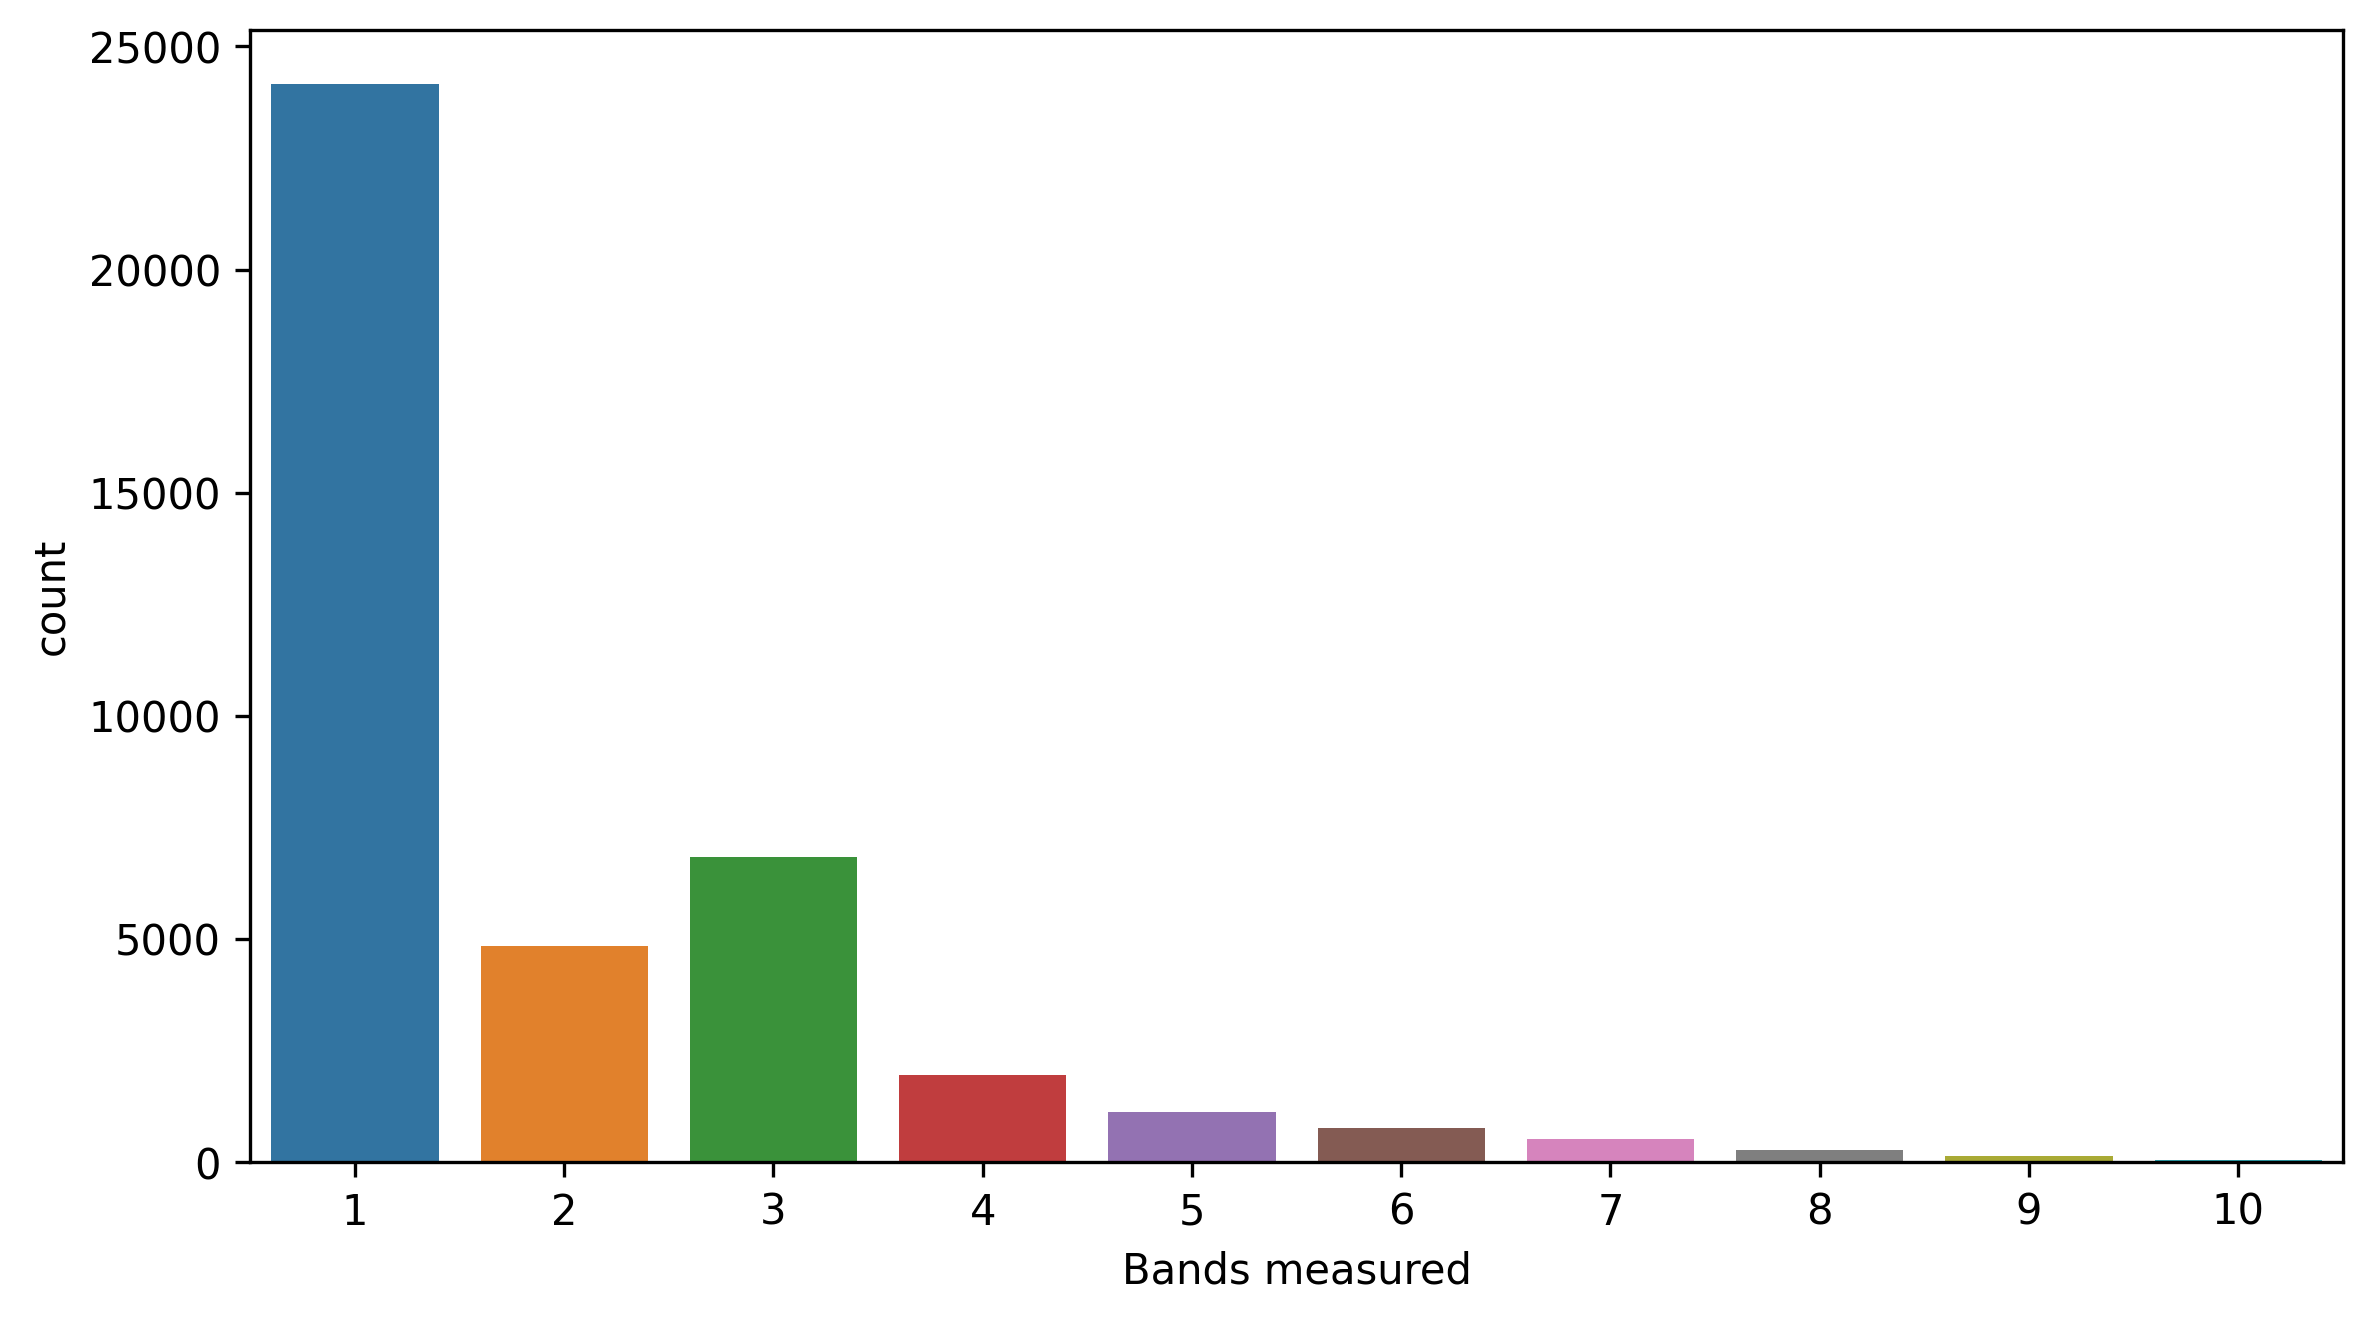

In [17]:
df_many = (df!=no_data).sum(axis=1)
no_mea = (df_many==0).sum()
percentage = no_mea/ether_sources*100
print('Sources without any measurement: {}'.format(no_mea))
print('Percentage of source without measurements: {:.2f}%'.format(percentage))

fig, ax = plt.subplots(1,figsize=(9,5), dpi=300)
sns.countplot(x=df_many[df_many!=0])
plt.xlabel('Bands measured')

df_many2 = df_many.value_counts()
df_many2.drop(index=df_many2.index[0], axis=0, inplace=True)
df_many2

Nearly 98\% of the ETHER catalogue have 0 measurements in radio bands, which represents a big problem in the context of the final purpose of the catalgue itself, but despite that, there's still a lot of sources that have at least 1 band measured, and any increase in the amount of band measured will affect positively the ADAF models, because at more bands measured, more accuaracy in the models. 10 sources have 9 bands measured, being excellent candidates to model. 

# eFEDS Analysis

According to eFEDS publications, no all the sources are AGN, so to reduce the computational cost, a filter to obtain just the AGN info is needed. In order to achive that, the eFEDS AGN catalogue delivers the ID of all the AGN sources, so that way they can be crossmatched with the eFEDS Main catalogue. Also, a hardband (HB) selected sample is provided, with sources that are and not in the Main catalogue (strange), so the final crtieria to match a source if the following:

* Be in the Main catalogue
* Be in the AGN catalogue
* Have a measured flux in the 2.3 to 5 keV band

And if the source is also a HB selected, a binary code will be created. This criteria is considered only to have sources with more than 1 band measured, that way these source are more probably AGN.

In [18]:
main_idx = main_cat['ID_SRC']                    #index on main catalogue
agn_idx = agn_main['ID_SRC']                    #index of agn catalogue
agn_powerlaw_idx = agn_powerlaw['ID_SRC']       #index of powerlaw fitting
hb_idx = hb_cat['ID_main'] 

#filter only hb selected that are on main eFEDS catalogue
hb_main = np.delete(hb_idx, hb_idx==-99, axis=0)    
#filter agns on main catalogue
agn_filter = main_cat[np.isin(main_idx, agn_idx)]                                        
#delete ones with 0 flux on 2.3 to 5 keV
agn_filter = np.delete(agn_filter, np.where(agn_filter['ML_FLUX_h']==0)[0], axis=0)     
#index of agns filter from main
agn_filter_idx = agn_filter['ID_SRC']               
#obtain agn powerlaw info of agns non-zero value sources
agn_powerlaw_info = agn_powerlaw[np.isin(agn_powerlaw_idx, agn_filter_idx)] 
#boolean list for if a source is hb selected or not
is_selected = 1*np.isin(agn_filter_idx, hb_main)        

z = agn_powerlaw_info['Redshift']
log_lum = agn_powerlaw_info['LumiIntr_BF_s']       #extract info from catalogues
log_lum_low = agn_powerlaw_info['LumiIntr_Lo1_s']
log_lum_upp = agn_powerlaw_info['LumiIntr_Up1_s']

err_up = abs(log_lum-log_lum_upp)
err_down = abs(log_lum-log_lum_low)

err = [err_down, err_up]

kde = stats.gaussian_kde(z)
xx = np.linspace(0, max(z), 1000)

agn_count = len(z)
percentage = agn_count/efeds_sources*100

print('Source before filtering: {}'.format(agn_count))
print('Percentage of AGN selected from catalogue: {:.2f}%'.format(percentage))

Source before filtering: 12832
Percentage of AGN selected from catalogue: 45.98%


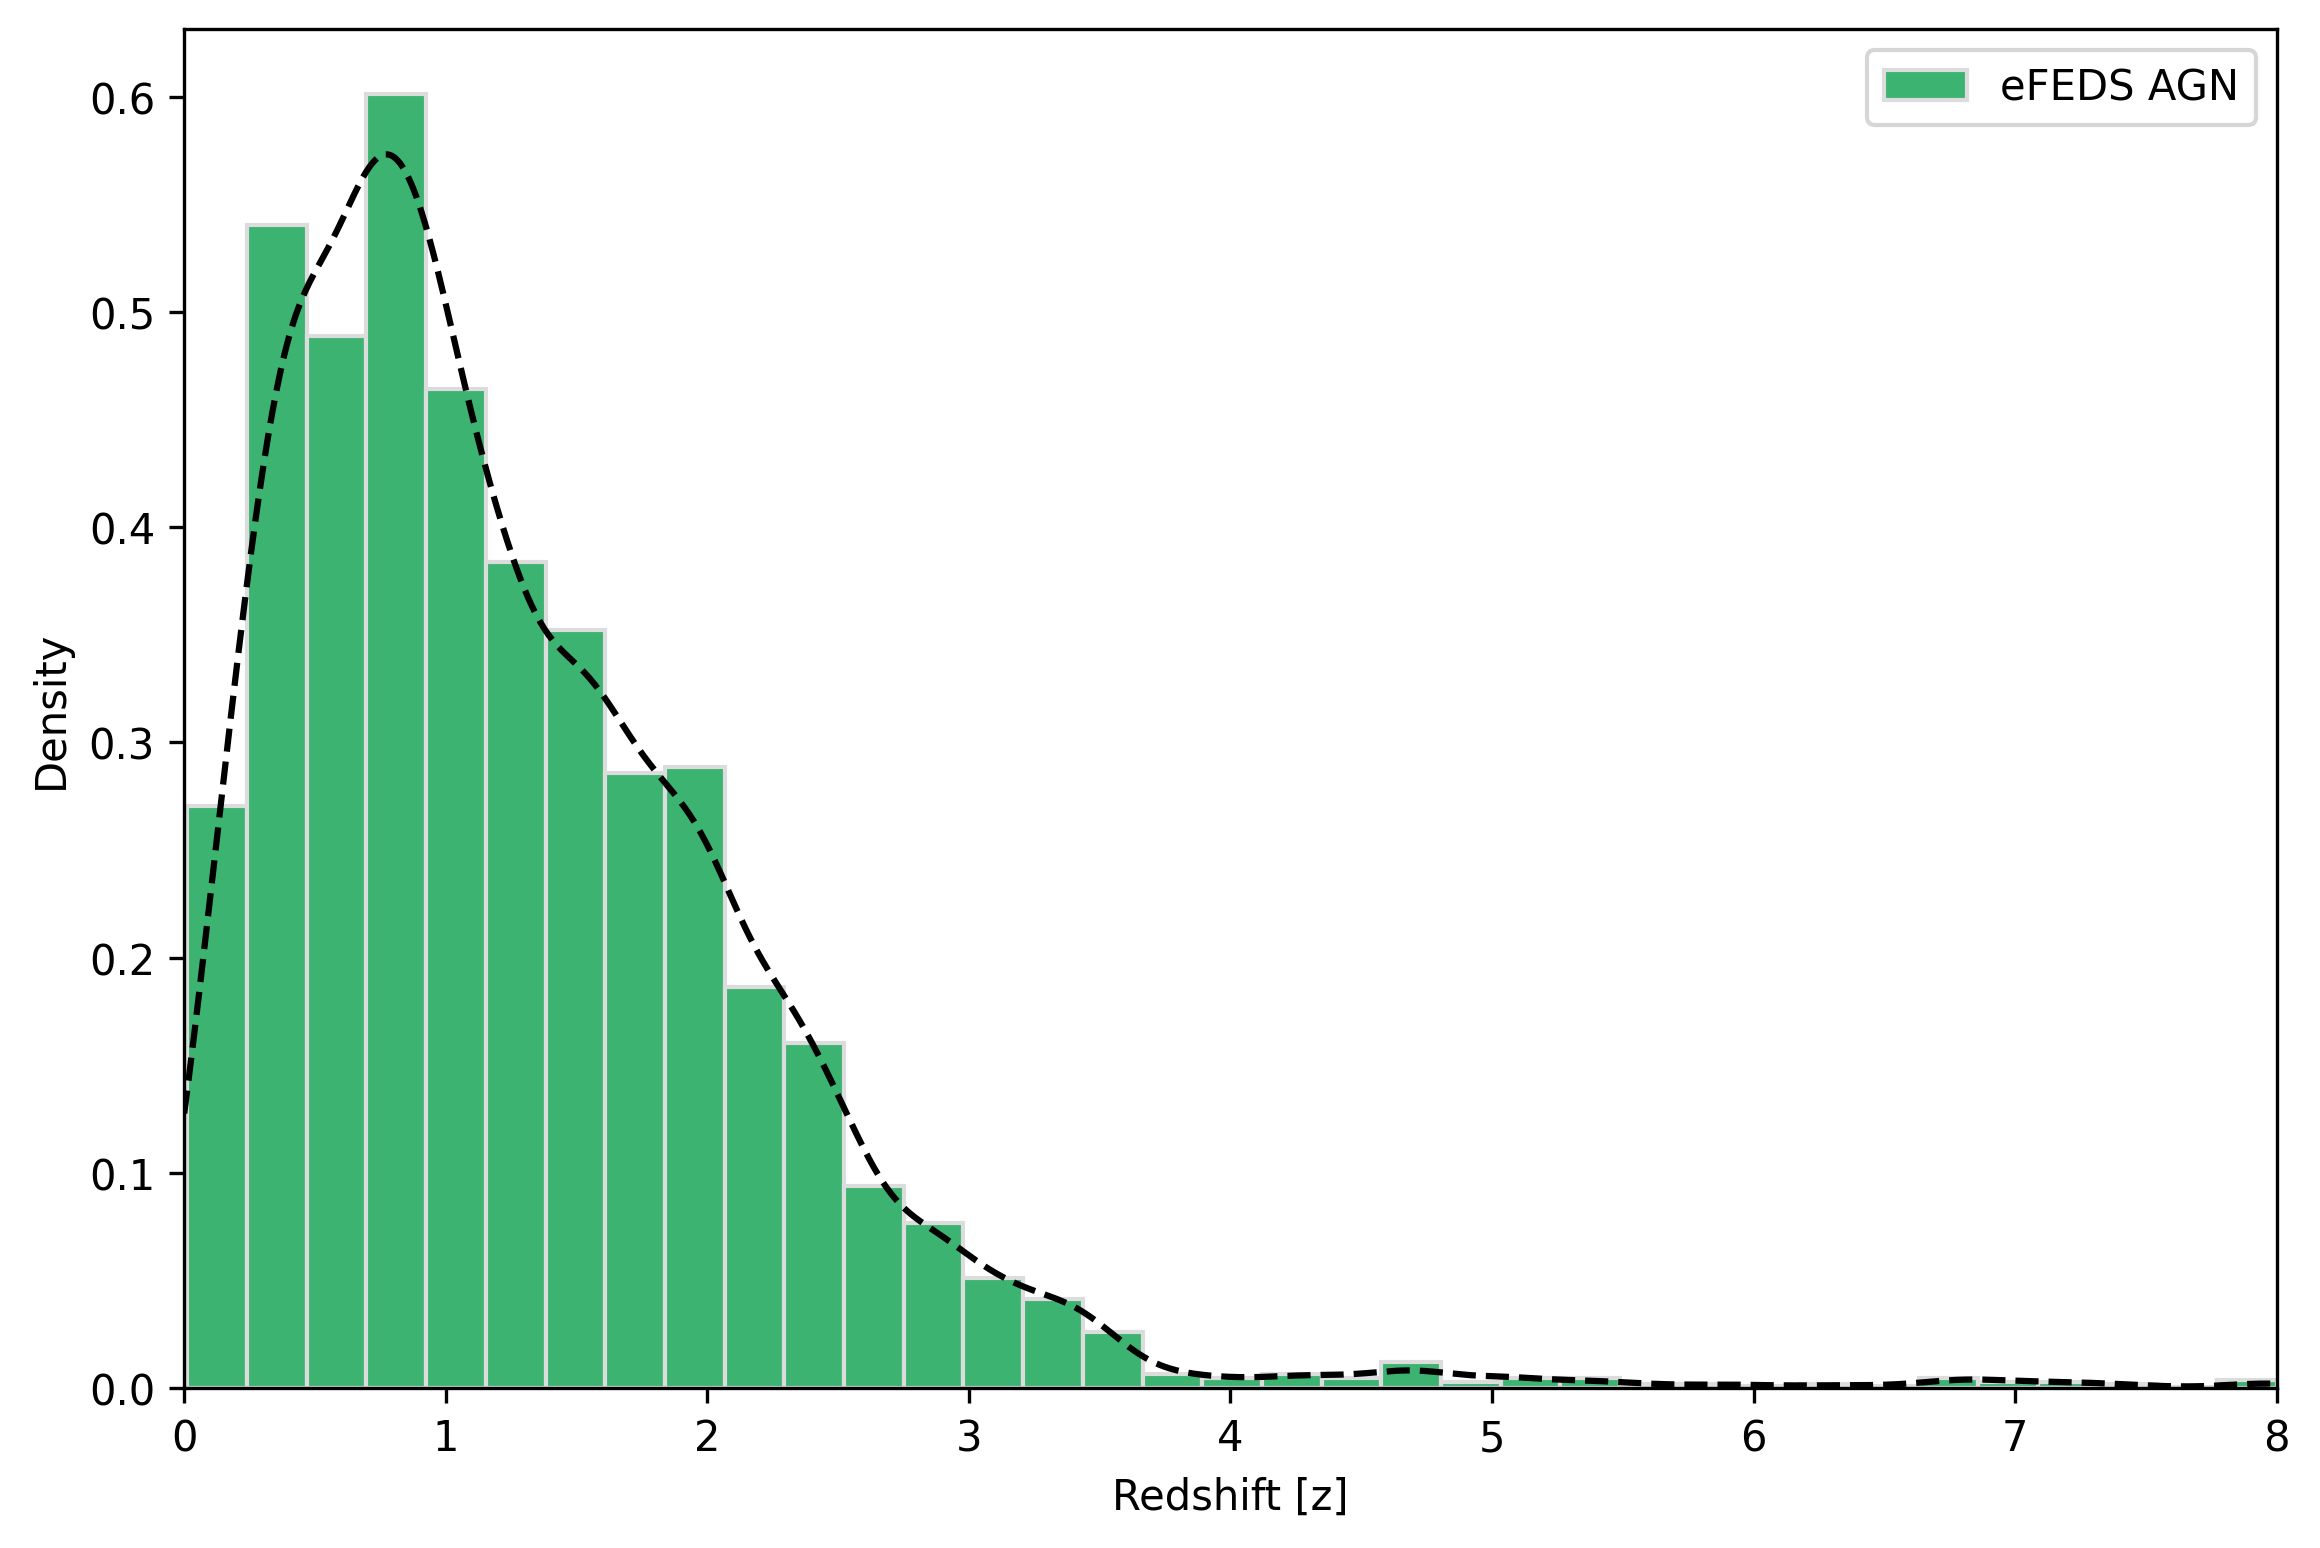

In [19]:
plt.figure(figsize=(9,6), dpi=300)
plt.plot(xx, kde(xx), color='black', linestyle='--')
plt.hist(z,
    bins=35,
    density=True,
    color='mediumseagreen',
    edgecolor='gainsboro',
    label='eFEDS AGN'
    )
plt.xlabel('Redshift [z]')
plt.ylabel('Density')
plt.margins(x=0)
plt.legend()

In [20]:
b2 = sum(z<=2)/agn_count*100
b4 = sum(z<=4)/agn_count*100

max_density = np.where(kde(xx)==max(kde(xx)))
a = xx[max_density[0]]

print('z maximum density = {:.2f}'.format(a[0]))
print('Sources below z = 2: {:.2f}%'.format(b2))
print('Sources below z = 4: {:.2f}%'.format(b4))

z maximum density = 0.78
Sources below z = 2: 81.66%
Sources below z = 4: 98.62%


After filtering, 12832 AGN were selected from the eFEDS catalogue, representing 45.98\% of the eFEDS catalogue. The distribution of this sample reach its maximum on z $\sim$ 0.8, 81.66\% of the sample is below z = 2 and 98.62\% is below z = 4.

In [21]:
agn_count/ether_sources*100

1.6003052951498227

With this numbers, now the eFEDS AGN sample represent only a 1.58\% of the ETHER catalogue, so the possible matches are now more constrained.

The 0.5 to 2 keV band (softband, SB) is fully measured for all the sources in the eFEDS catalogue, so it is the best information provided in this data release. 

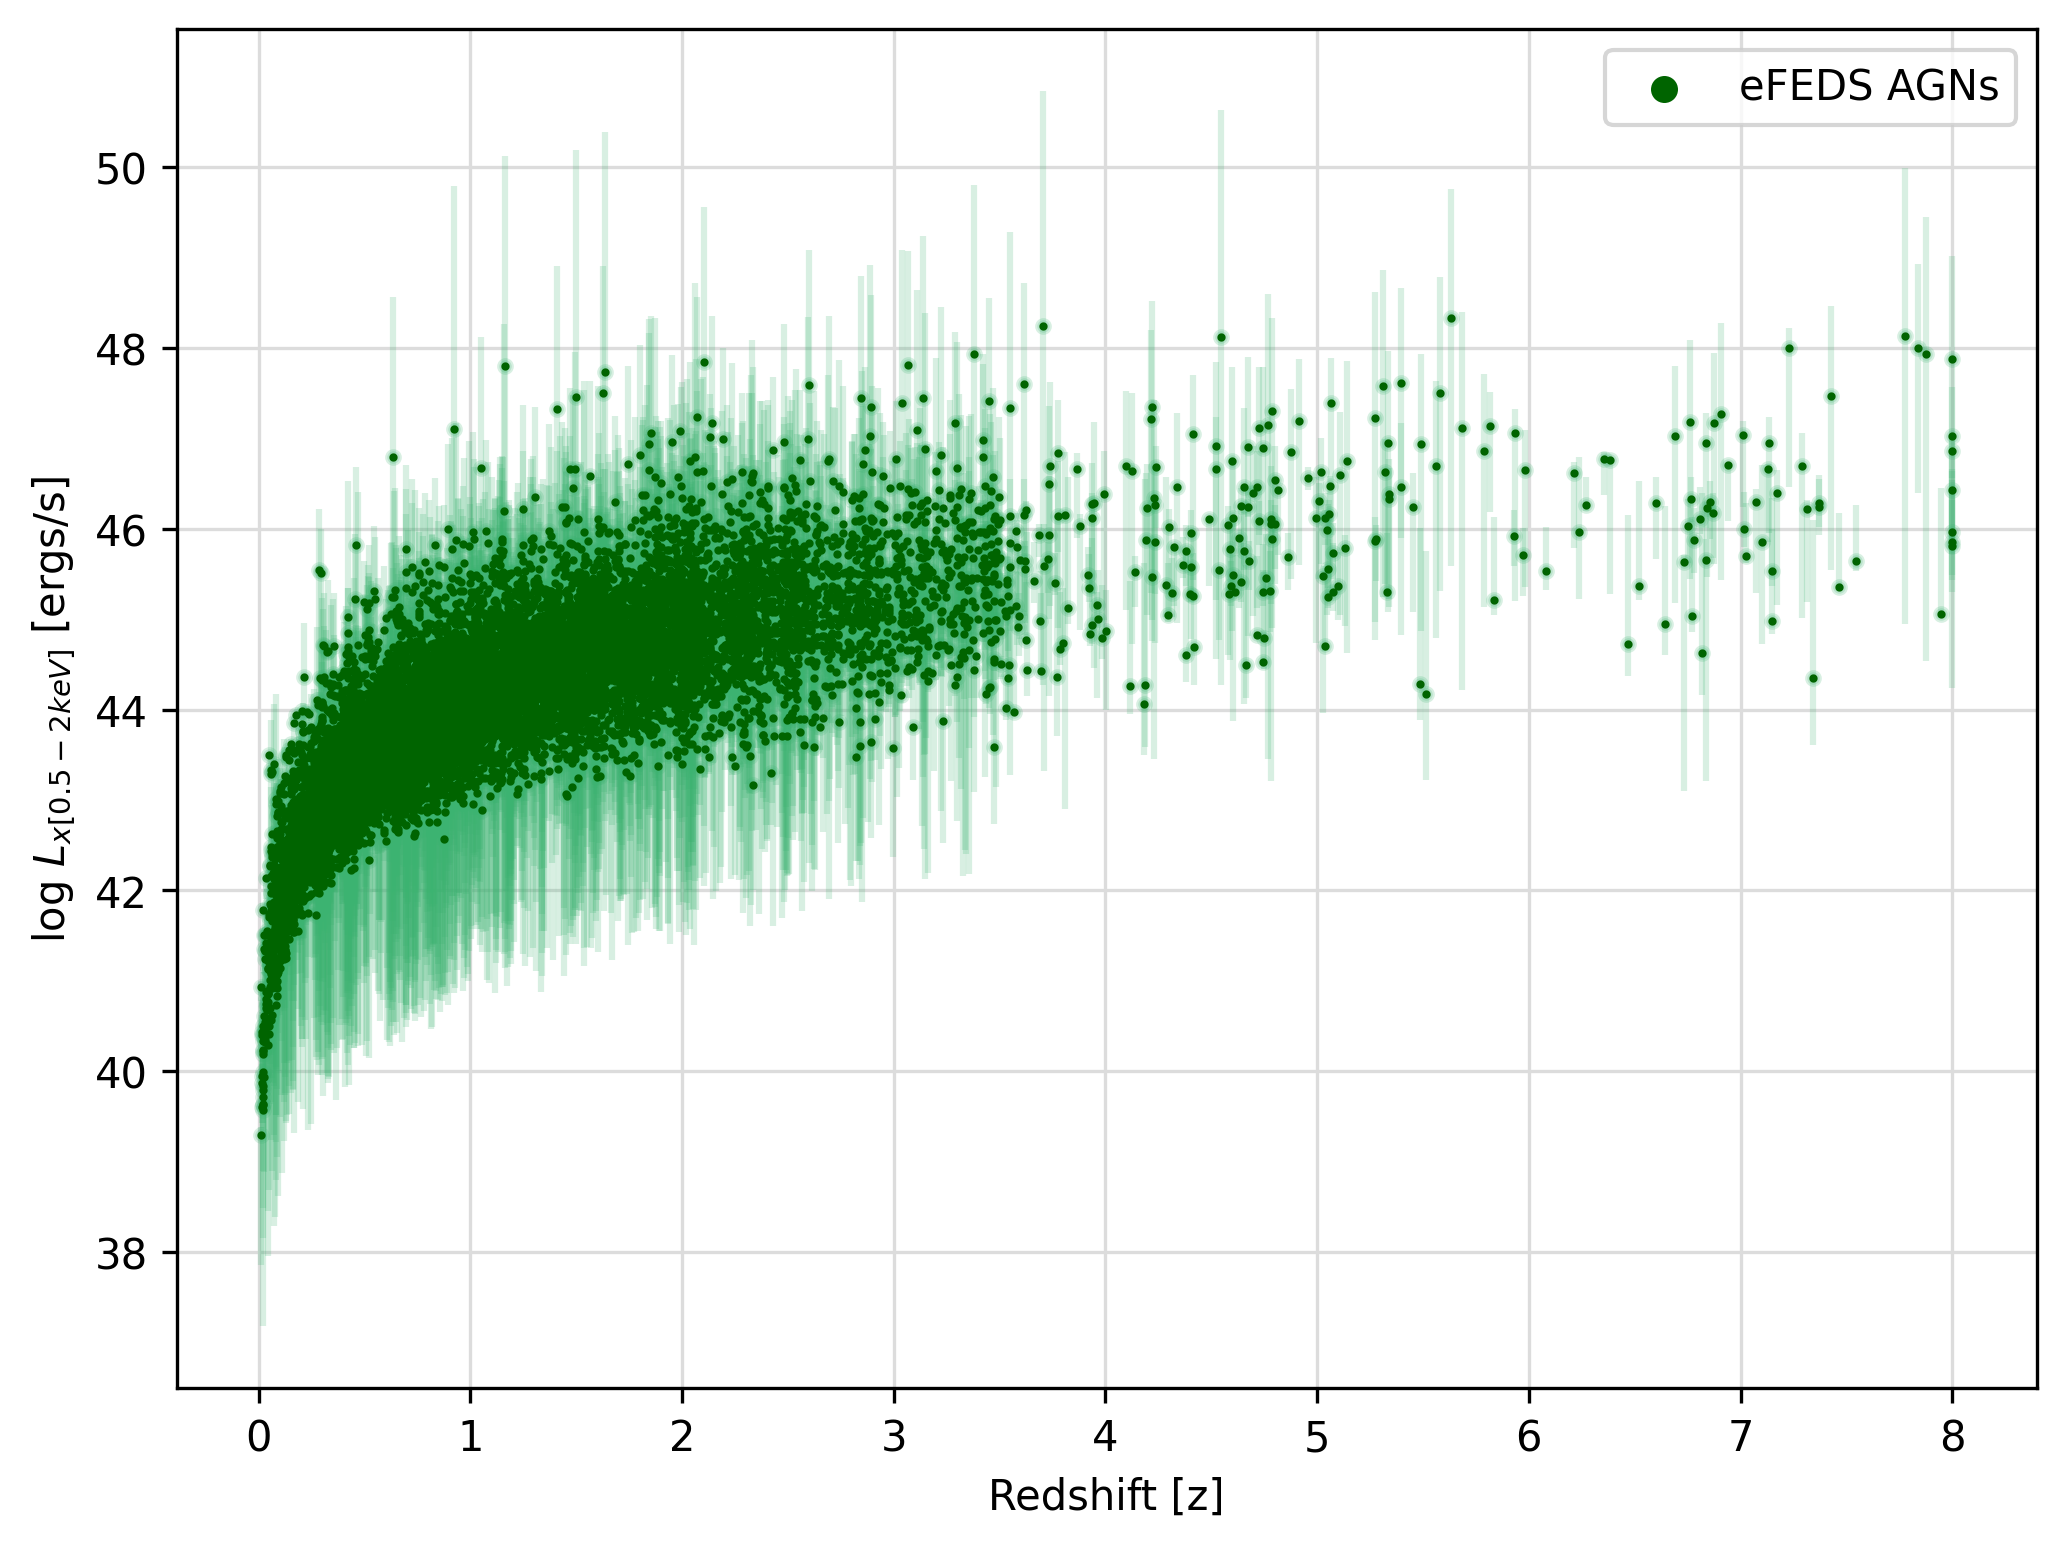

In [22]:
plt.figure(dpi=300, figsize=(8,6))
plt.scatter(
    z,
    log_lum,
    c='darkgreen',                       
    s=1,
    zorder=3,
    label=r'eFEDS AGNs')
plt.errorbar(
    z,
    log_lum,                                              
    yerr = err,
    color='mediumseagreen',
    fmt='.',
    alpha=0.2,
    zorder=2)
plt.xlabel(r'Redshift [z]')
plt.ylabel(r'log $L_{x[0.5-2 keV]}$ [ergs/s]')
plt.grid(zorder=0, color='gainsboro')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]

The distribution of the sources shows a clear downfall on the luminosities where z < 2, beng the closest sources the less luminous ones. The measurements present huge uncertainties, so any measure with them will have to be take with a pinch of salt.

# Crossmatch between Catalogues

In [23]:
tol_coord = 3                       #tolerance of crossmatch in arcsec

lim_RA_l, lim_RA_u = 126, 146       #limits to masking RA on ETHER

lim_DEC_l, lim_DEC_u = -3, 6 

#masking ETHER catalogue for less computational time
cond_RA = (ethercat['RA']>lim_RA_l) & (ethercat['RA']<lim_RA_u)   
cond_DEC = (ethercat['DEC']>lim_DEC_l) & (ethercat['DEC']<lim_DEC_u)

cond = cond_RA*cond_DEC
ethercat = ethercat[cond]

With the objective to reduce computational cost, I masked the ETHER sample to the region where the eFEDS sample is located (manually), that way the crossmatch don't pass trough all the sky region of the 800k sources.

In [24]:
tol_coord = tol_coord/3600  

to_append = ['eFEDS_ID','eFEDS_Name','ONAME','Z','RA','DEC','Mbh','Mbh_Method','Fx_soft','Lx_soft','Lx_lo1','Lx_up1','Fr_5','HB_Sel']
final_sample = np.empty((0,len(to_append)), str)             #array to append important values after crossmatch with ether
RA_et = ethercat['RA']
DEC_et = ethercat['DEC']            #RA, DEC to compare and Name to save if match
oname = ethercat['ONAME']
radio5 = ethercat['FLUX5']

print('Crossmatching with a tolerance of {} arc-second(s) differennce'.format(tol_coord*3600))
count = 0  
for i in np.arange(len(agn_filter)):
    efedsid = agn_filter['ID_SRC'][i]
    efedsname = agn_filter['Name'][i]
    redshift = agn_powerlaw_info['Redshift'][i]
    ra_hb = agn_filter['RA_CORR'][i]
    dec_hb = agn_filter['DEC_CORR'][i]
    Fxs = agn_filter['ML_FLUX_s'][i]
    log_lum = agn_powerlaw_info['LumiIntr_BF_s'][i]
    log_lum_low = agn_powerlaw_info['LumiIntr_Lo1_s'][i]
    log_lum_upp = agn_powerlaw_info['LumiIntr_Up1_s'][i]
    select = is_selected[i]

    matches = 0                         #count of matches
        
    dist = np.sqrt((ra_hb-RA_et)**2 + (dec_hb-DEC_et)**2)           #Substraction to analyze

    cond = (dist==min(dist))*(dist<=tol_coord)                  #Boolean array of condition after match
    cond = [i for i, x in enumerate(cond) if x]                 #Takes the index of True values only
        
    for i in cond:
        final_sample = np.append(final_sample, np.array([[efedsid,efedsname,oname[i],redshift,ra_hb,dec_hb,mbh[i],mbhsource[i],Fxs,log_lum,log_lum_low,log_lum_upp,radio5[i],select]]), axis=0)
        matches += 1
        count += 1

print('Total matches: {}'.format(count))

df_cross = pd.DataFrame(final_sample, columns=to_append)
df_cross

Crossmatching with a tolerance of 3.0 arc-second(s) differennce
Total matches: 868


eFEDS_ID              eFEDS_Name               ONAME         Z  \
0          7  eFEDS J091702.3-004415  091702.38-004417.5  0.322346   
1          9  eFEDS J091401.7+050749  091401.76+050750.6   0.30134   
2         11  eFEDS J084302.9+030218  084302.96+030218.9  0.512114   
3         24  eFEDS J090910.2+012135    2FGLJ0909.1+0121   1.02422   
4         28  eFEDS J093117.8+033118  093117.80+033119.5  0.204952   
..       ...                     ...                 ...       ...   
863    29858  eFEDS J090241.0+032932  090241.16+032930.9   2.37302   
864    30174  eFEDS J091443.6-020016  091443.65-020014.3    2.2358   
865    30974  eFEDS J091715.3-022304  091715.27-022306.8   1.28666   
866    31136  eFEDS J093426.3+043014  093426.23+043015.0  0.655032   
867    31557  eFEDS J084532.6+012348  084532.79+012350.1   1.57085   

                     RA                  DEC        Mbh Mbh_Method  \
0    139.25958886351057  -0.7375046618167612  7.0304933        1.0   
1     138.5074734496979    5.130529581471579    6.91206        1.0   
2    130.76233479861034   3.0384431599404773   8.083829        1.0   
3    137.29266802821107   1.3598245967545737  7.6228766        1.0   
4    142.82451644263642    3.521780635615849  7.3887916        1.0   
..                  ...                  ...        ...        ...   
863  135.67104750602996    3.492351969941289   8.171112        1.0   
864  138.68189033484282   -2.004556701404369  7.0758047        1.0   
865   139.3138821860783  -2.3846881941872806  7.7510304        2.0   
866  143.60972138427658    4.504088793655702  9876543.0  9876543.0   
867   131.3859768666733   1.3969348734693212   8.293786        1.0   

                    Fx_soft  Lx_soft   Lx_lo1   Lx_up1       Fr_5 HB_Sel  
0     9.755255982408446e-13  44.6365  44.6297  44.6488  9876543.0      1  
1     1.435616908623394e-12  44.7111  44.7038  44.7257       34.0      1  
2       7.1965072460459e-13  45.1138  45.1074  45.1353  9876543.0      1  
3     5.442696492380664e-13   45.494   45.481  45.5333      777.0      1  
4      4.84218357766957e-13  43.8394  43.8285  43.8584  9876543.0      1  
..                      ...      ...      ...      ...        ...    ...  
863   5.438596969055964e-15   43.931  42.9032  45.1315  9876543.0      0  
864  3.1619528269985573e-15  43.4745  43.6189  44.6533  9876543.0      0  
865   1.503916302774984e-14   44.112  43.9833  44.6352  9876543.0      0  
866   6.874555858787215e-15  42.6673  41.9517  43.5668  9876543.0      0  
867    3.76409730403512e-15  44.1404  41.3658   44.042  9876543.0      0  

[868 rows x 14 columns]

In [25]:
count/ether_sources*100

0.10825007763326419

This is a simplified version of the crossmatch code that I wrote for this purpose. This amount of sources represent less than 1\% of the ETHER catalogue, so its not a representative sample. The positive thing of this is that the code functions and its prepared for larger catalogues, like the eROSITA All Sky Survey (eRASS) which is expected to be published at the Q4 of 2022. It is expected to have more than 1 million sources, so the masking of the sky regions becomes pointless and have to be removed at that moment.

# MBH Estimations with eFEDS Data

eFEDS catalogue provides lot of information about its sources and will provide even more in the future with the eRASS publication. Then, it is extremely necessary to be able to extract as much information as we can from that data. ETHER purpose is to provide a huge sample of promising sources to be imaged in the future with the (ng-)EHT. Fluxes and luminosity modelling is necesary in order to classify this sources from the ones with the most to the least possibilities to be imaged with the facillities at the moment, and MBH is a key parameter to do that modelling. X-ray and Radio data is also necessary, and the first one will be provided by eRASS. The methods to estimate MBH lose reliability when the source is more distant (in terms of redshift), so the use of X-ray-only-methods to estimate MBH will potentially give us masses for more than 1 million sources (expected amount of sources for eRASS). I'm already writing a separate report about this methods (just relations), but here I'll present quickly the codes and main results (no much discussion about it, consult the report for that)

# Variablity-Mass Relation

Normalised Excess Variance ($\sigma^2_\text{rms}$) is used to estimate X-ray variability in AGN emission, and many authors have found that this statistical value have a co-relation between luminosity and mass, so this points toward another relation to that I present later in this notebook. The Variability-Mass relation was studies before only for HB emission, and eFEDS only provides it for SB, so this case of study is just to test this relaitons with SB data.

Here I defined the relations found by other authors (comment) with the use of the uncertainties package to handle error propagation

In [26]:
from uncertainties import ufloat, unumpy
import uncertainties.umath as u

def mbh_ponti_10ks(nev):
    mbh = (nev+ufloat(2.2,0.14))/(ufloat(-1.21,0.1))+7              #nev-Mbh relation for 10ks (Ponti et al. 2012)
    return mbh

def mbh_ponti_20ks(nev):
    mbh = (nev+ufloat(2.13,0.14))/(ufloat(1.24,0.12))+7             #nev-Mbh relation for 20ks (Ponti et al. 2012)
    return mbh

def mbh_lu_yu(nev):          
    mbh = 4.75 - nev                                                #nev-Mbh relation (Lu & Yu. 2001)
    return mbh

def mbh_mayers_10ks(nev):
    mbh = (nev-ufloat(0.003,0.043))/(ufloat(-1.27,0.65))+7.301      #nev-Mbh relation for 10ks (Mayers et al. 2018)
    return mbh

In [27]:
maincat = fits.open('../eROSITA/eFEDS_c001_main_V7.4.fits')
varcat = fits.open('../eROSITA/eFEDS_c001_Lightcurves_softhard_V5.fits')
agncat = fits.open('../eROSITA/eFEDS_AGN_spec_V17.6.fits')

varsample = varcat[1].data
basicinfo = maincat[1].data
plawsample = agncat[7].data             #total sources               
agnsample = agncat[1].data              #AGN sources
tot_idx = plawsample['ID_SRC']                  #indexes of all sources
agn_idx = agnsample['ID_SRC']                   #indexes of AGN sources
not_agn = [x for x in tot_idx if x not in agn_idx]

agn_basicinfo = np.delete(basicinfo, np.where(np.isin(tot_idx,not_agn))[0], axis=0)
agn_pwlaw = np.delete(plawsample, np.where(np.isin(tot_idx,not_agn))[0], axis=0)

var_fil = np.delete(varsample, np.where(varsample['isvariable_0']==False)[0], axis=0)
var_fil = np.delete(var_fil, np.where(var_fil['nev_det_0']==False)[0], axis=0)

var_idx = var_fil['SRCID']

agn_efeds_info = np.delete(agn_basicinfo, np.where(~np.isin(agn_idx,var_idx))[0], axis=0)

agn_var_pwlaw = np.delete(agn_pwlaw, np.where(~np.isin(agn_idx,var_idx))[0], axis=0)

agn_var_basic = np.delete(agnsample, np.where(~np.isin(agn_idx,var_idx))[0], axis=0)

agn_var_varia = np.delete(var_fil, np.where(~np.isin(var_idx,agn_idx))[0], axis=0)

y = agn_var_varia['nev_0']
err = agn_var_varia['nev_err_0']
y_log = np.log10(y)

print('Sources with nev measured in SB: {}'.format(len(y)))

Sources with nev measured in SB: 2


The eFEDS sample just provide $\sigma^2_\text{rms}$ for 2 AGN, so it's not possible to derive a relation, even with resampling, there's no enough data to do that, so I'll limit to just test previous relations.

In [28]:
to_append = ['eFEDS ID','eFEDS Name','RA','DEC','NEV','Mbh Ponti 10ks','Mbh Ponti 20ks','Mbh Lu-Yu','Mbh Mayers 10ks']
nev_sample = np.empty((0,len(to_append)), str)             #array to append important values after crossmatch with ether
for i in range (len(y)):
    efedsid = agn_efeds_info['ID_SRC'][i]
    efedsname = agn_efeds_info['Name'][i]
    ra_hb = agn_efeds_info['RA_CORR'][i]
    dec_hb = agn_efeds_info['DEC_CORR'][i]
    nev = y_log[i]
    nev_err = err[i]

    nev = ufloat(nev,nev_err)

    mbhponti10ks = mbh_ponti_10ks(nev)
    mbhponti20ks = mbh_ponti_20ks(nev)
    mbhluyu = mbh_lu_yu(nev)
    mbhmayers10ks = mbh_mayers_10ks(nev)

    nev_sample = np.append(nev_sample, np.array([[efedsid,efedsname,ra_hb,dec_hb,nev,mbhponti10ks,mbhponti20ks,mbhluyu,mbhmayers10ks]]), axis=0)     #Save the info of the match source into the array

df_nev = pd.DataFrame(nev_sample, columns=to_append)
df_nev

eFEDS ID              eFEDS Name          RA       DEC             NEV  \
0        1  eFEDS J093700.9+010545  144.253833   1.09592  -1.486+/-0.006   
1        3  eFEDS J085617.8-013805   134.07417 -1.634745  -1.710+/-0.006   

  Mbh Ponti 10ks Mbh Ponti 20ks      Mbh Lu-Yu Mbh Mayers 10ks  
0    6.41+/-0.13    7.52+/-0.12  6.236+/-0.006       8.5+/-0.6  
1    6.60+/-0.12    7.34+/-0.12  6.460+/-0.006       8.7+/-0.7

In the case of source ID 1, a previous estimations of it mass was Mbh = 6.6, so Ponti-10ks and Lu-Yu relations are not that far for that case, but being just one, it has no statistical significance.

# Luminosity-Mass relation

This one is comes fromes the point that a more massive SMBH will accrete more mass in it, thus, more luminosity. This an expected behavior, but normally, this is expected to happen in HB, due to the mor energetic origin of the emission. In fact, the Luminosity-Mass relation was studied before for HB luminosities, but eFEDS provides sufficient SB luminosities to do this analysis and derive a relation and it's error via resampling.

In [29]:
from sklearn.utils import resample

def linear_with_ci(x,y,hconf=0.975,lconf=0.875):
    p, cov = np.polyfit(x, y, 1, cov=True)                      # parameters and covariance from of the fit of 1-D polynom.
    y_model = np.polyval(p, x) 

    n = y.size                                                  # number of observations
    m = p.size                                                  # number of parameters
    dof = n - m                                                 # degrees of freedom
    t1 = stats.t.ppf(hconf, n - m)                              # used for CI and PI bands
    t2 = stats.t.ppf(lconf, n - m)                              # used for CI and PI bands

    resid = y - y_model                           
    chi2 = np.sum((resid / y_model)**2)                         # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                       # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                     # standard deviation of the error

    x2 = np.linspace(np.min(x)-2, np.max(x)+2, 100)
    y2 = np.polyval(p, x2)

    ci1 = t1 * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ci2 = t2 * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

    pi = t1 * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2)) 

    return x2, y2, ci1, ci2, p, pi

To study this relation, I used the power-law derived X-ray luminosity in SB from eFEDS sample and MBH measurements from studies by Greene et al, Shen et al, and Ho et al.

In [30]:
df_agn = pd.read_csv('../eROSITA/MBHvir_sample.csv')
df_agn

eFEDS_ID              eFEDS_Name                 SDSS_Name         z  \
0          24  eFEDS J090910.2+012135        090910.09+012135.6  1.024220   
1          29  eFEDS J091333.6-004250        091333.66-004250.9  0.426261   
2          31  eFEDS J093518.2+020415        093518.19+020415.5  0.649871   
3          33  eFEDS J084110.8+022950        084110.88+022952.1  0.332316   
4          46  eFEDS J085240.1+051216        085240.12+051215.4  0.226247   
..        ...                     ...                       ...       ...   
595     23151  eFEDS J092548.8+031613       J092548.97+031613.5  0.162960   
596     23548  eFEDS J085333.7-003056       J085333.72-003055.1  0.188534   
597         4  eFEDS J084025.4+033302  SDSS J084025.51+033301.7  0.060387   
598        61  eFEDS J093240.4+023332  SDSS J093240.55+023332.6  0.056903   
599       352  eFEDS J093259.6+040504  SDSS J093259.60+040506.0  0.059225   

             RA       DEC    Mbh  Lx_soft   Lx_lo1   Lx_up1        Fx_med  \
0    137.292668  1.359825  9.182  45.4940  45.4810  45.5333  4.981680e-13   
1    138.390051 -0.714123  9.057  44.5839  44.5728  44.6053  3.250090e-13   
2    143.826013  2.070927  9.563  45.0000  44.9845  45.0316  4.295250e-13   
3    130.295197  2.497452  8.589  44.2988  44.2899  44.3253  4.025370e-13   
4    133.167116  5.204541  8.355  43.9754  43.9630  44.0005  5.709720e-13   
..          ...       ...    ...      ...      ...      ...           ...   
595  141.453335  3.270521  6.800  41.5525  39.8930  42.0050  6.930490e-13   
596  133.390562 -0.515650  7.100  43.5533  42.3467  43.4077  9.012050e-14   
597  130.106096  3.550809  6.710  43.3089  43.3030  43.3175  1.197500e-12   
598  143.168744  2.559066  7.250  42.4739  42.4594  42.4998  7.129830e-13   
599  143.248381  4.084710  7.350  42.0480  42.0155  42.0848  1.397400e-13   

           Fx_lo1        Fx_up1     Cat  
0    4.275440e-13  6.455600e-13    Shen  
1    2.512660e-13  4.161290e-13    Shen  
2    3.266950e-13  5.213270e-13    Shen  
3    1.807220e-13  3.472730e-13    Shen  
4    1.923940e-13  4.192970e-13    Shen  
..            ...           ...     ...  
595  8.646340e-18  3.033220e-14  Greene  
596  1.112230e-16  1.024000e-13  Greene  
597  1.078560e-12  1.386750e-12      Ho  
598  2.766340e-13  4.786000e-13      Ho  
599  1.024410e-13  2.190430e-13      Ho  

[600 rows x 14 columns]

In [31]:
cat = df_agn['Cat']
mbh = df_agn['Mbh'].astype(float)
l_x = df_agn['Lx_soft'].astype(float)
l_x_low = df_agn['Lx_lo1'].astype(float)
l_x_upp = df_agn['Lx_up1'].astype(float)

l_x_low_sub = abs(l_x-l_x_low)
l_x_upp_sub = abs(l_x_upp-l_x)


In [32]:
x2, y2, ci1, _, p, pi = linear_with_ci(l_x, mbh)

rho1, pval1 = stats.spearmanr(mbh, l_x)                     #Spearman statistical test
rho2, pval2 = stats.pearsonr(mbh, l_x)                      #Pearson statistical test

print('Spearman relation test values:\n{}\n{}'.format(rho1,pval1))
print('Pearson relation test values:\n{}\n{}'.format(rho2,pval2))

Spearman relation test values:
0.7788297788943097
3.05456314025569e-123
Pearson relation test values:
0.7816937182821929
9.995324572417486e-125


The Spearm and Pearson relation tests gives similar factors of correlation in the data ($\sim$0.8) and low p-values, so the null hypothesis can be rejcted in both tests.

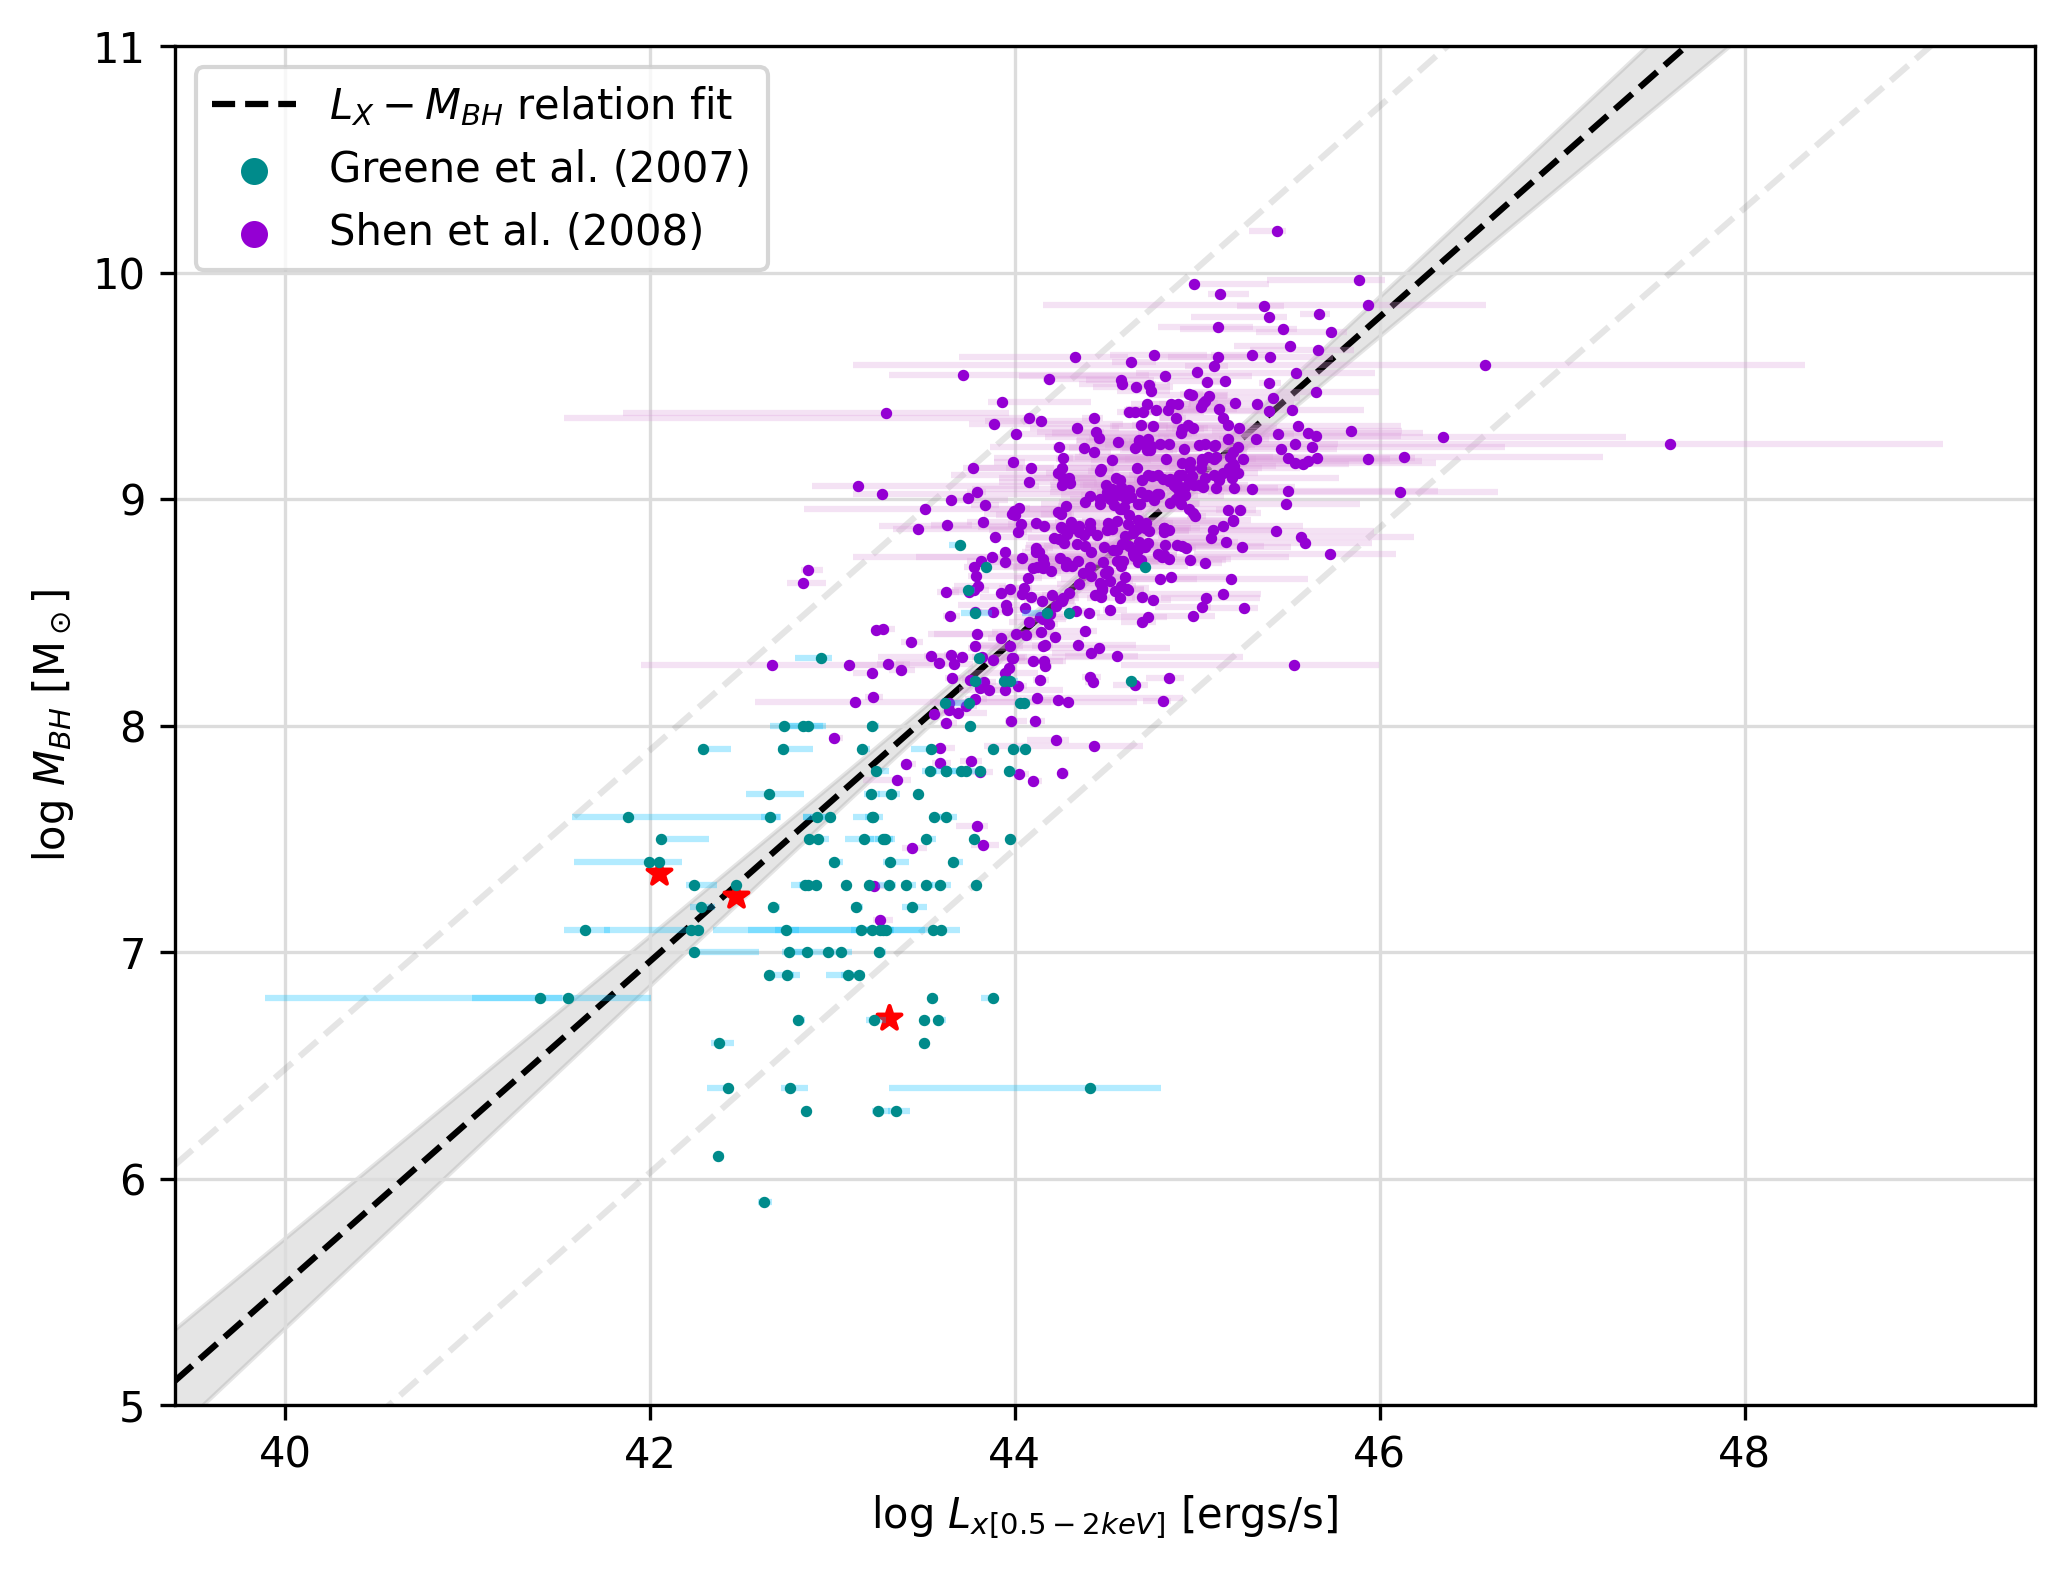

In [33]:
plt.figure(dpi=300, figsize=(8,6))
plt.plot(x2, y2, '--k', zorder=2,label=r'$L_X-M_{BH}$ relation fit')
plt.plot(x2, y2-pi, linestyle='--', color='grey', alpha=0.2)
plt.plot(x2, y2+pi, linestyle='--', color='grey', alpha=0.2)
plt.fill_between(x2, y2 + ci1, y2 - ci1,color='grey',alpha=0.2)
plt.scatter(
    l_x[cat=='Greene'],
    mbh[cat=='Greene'],
    c='darkcyan',
    s=3,                
    zorder=5,
    label=r'Greene et al. (2007)'
)
# https://ui.adsabs.harvard.edu/abs/2007ApJ...667..131G/abstract Greene+
plt.errorbar(
    l_x[cat=='Greene'],
    mbh[cat=='Greene'],
    c='deepskyblue',
    xerr=[l_x_low_sub[cat=='Greene'], l_x_upp_sub[cat=='Greene']],
    alpha=0.3,
    ls = 'none',
    zorder=4
)
plt.scatter(
    l_x[cat=='Shen'],
    mbh[cat=='Shen'],
    c='darkviolet',
    s=3,                
    zorder=3,
    label=r'Shen et al. (2008)'
)
# https://ui.adsabs.harvard.edu/abs/2008ApJ...680..169S/abstract Shen+
plt.errorbar(
    l_x[cat=='Shen'],
    mbh[cat=='Shen'],
    c='plum',
    xerr=[l_x_low_sub[cat=='Shen'], l_x_upp_sub[cat=='Shen']],
    alpha=0.3,
    ls = 'none',
    zorder=2
)
plt.scatter(
    l_x[cat=='Ho'],
    mbh[cat=='Ho'],
    c='red',                
    zorder=3,
    marker='*'
)
# https://iopscience.iop.org/article/10.1086/588217 Ho+
plt.errorbar(
    l_x[cat=='Ho'],
    mbh[cat=='Ho'],
    c='salmon',
    xerr=[l_x_low_sub[cat=='Ho'], l_x_upp_sub[cat=='Ho']],
    alpha=0.3,
    ls = 'none',
    zorder=2
)
plt.xlabel(r'log $L_{x[0.5-2 keV]}$ [ergs/s]')
plt.ylabel(r'log $M_{BH}$ [M$_\odot$]')
plt.ylim(5,11)
plt.margins(x=0)
lgnd = plt.legend()
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
plt.grid(zorder=0, color='gainsboro')

The distribution present considerable scatter and errors in luminosity, but the tendency is clear. The sources from Shen et al. covers the top-regime of SMBH masses, while Greene et al. sources covers the bottom-regime, near IMBH masses, so the tendency appears to be present in the whole SMBH mass regime.

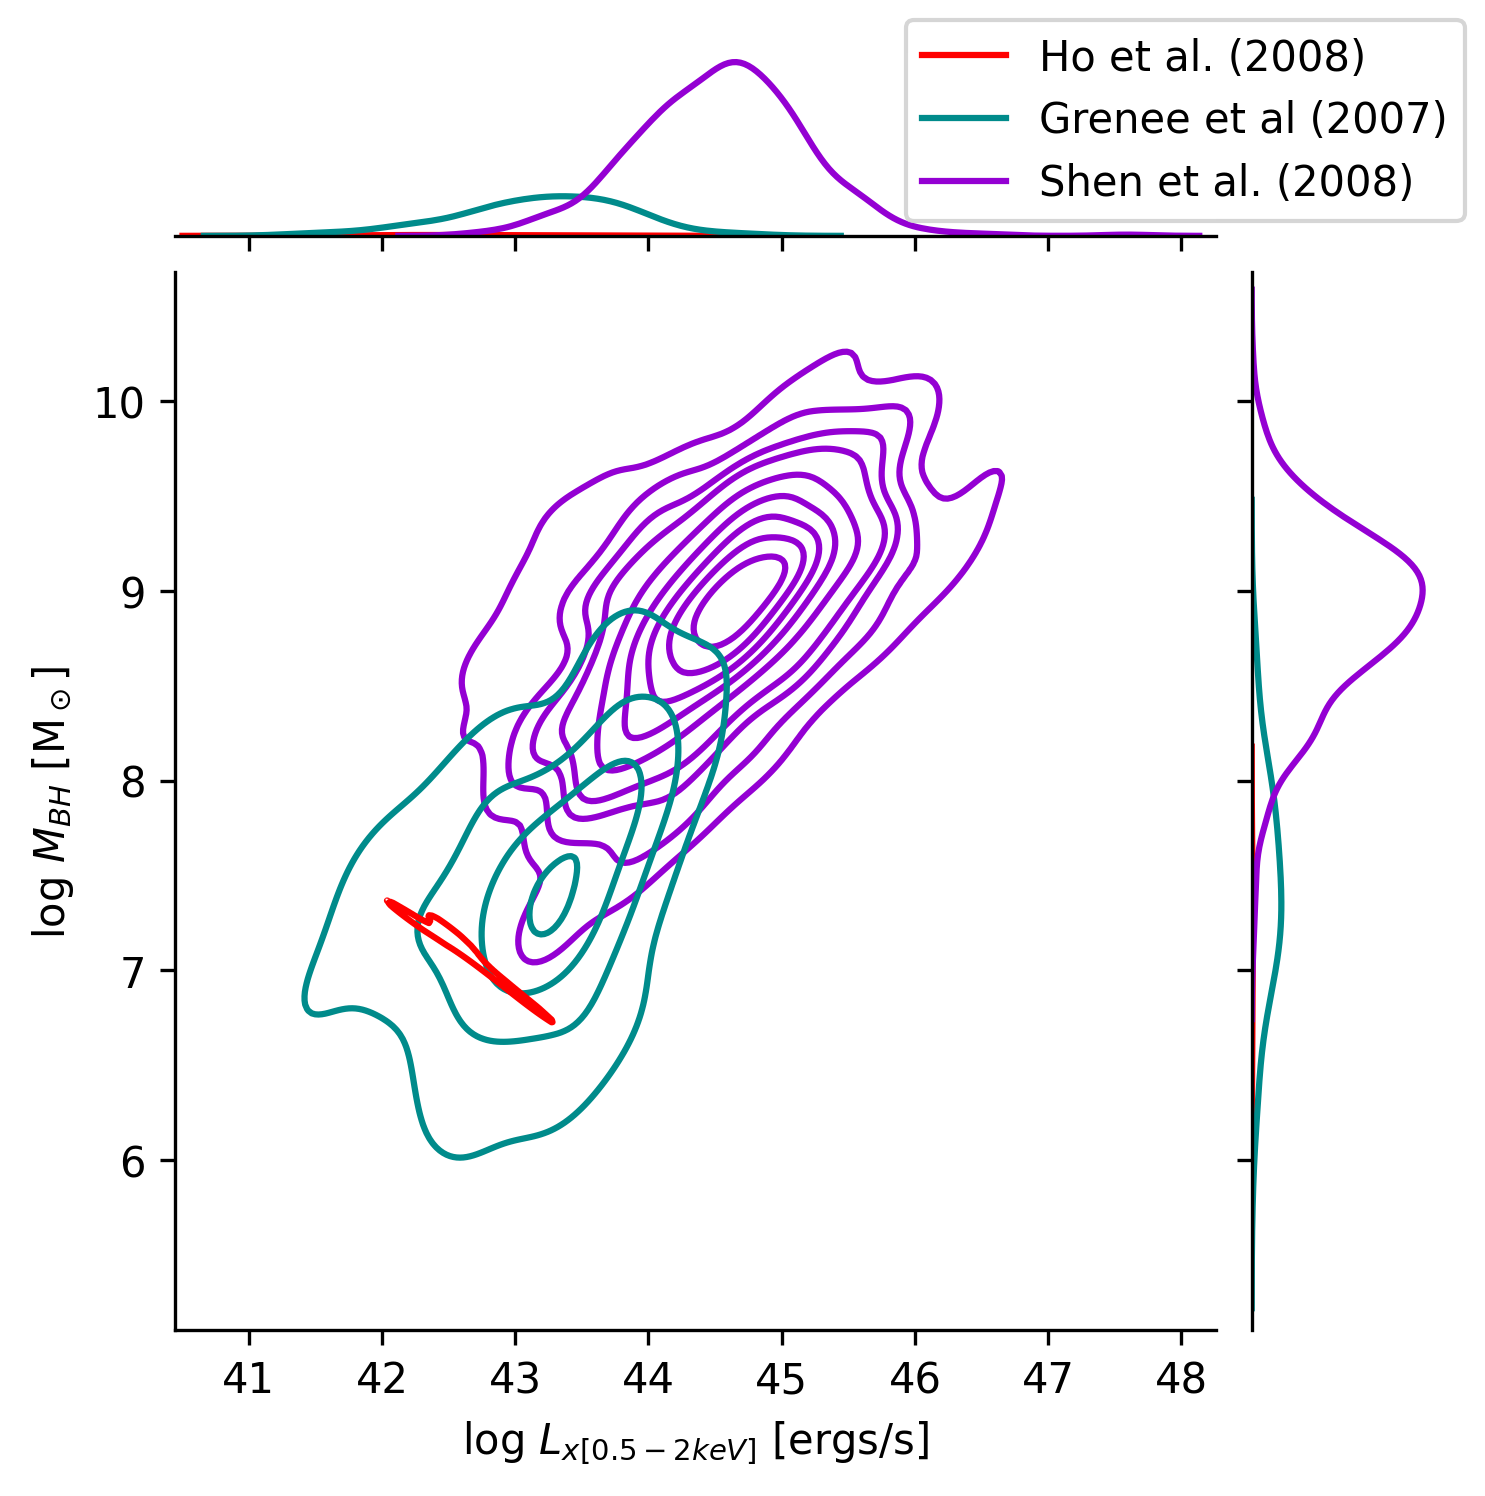

In [34]:
g = sns.jointplot(x='Lx_soft',y='Mbh',hue='Cat',kind='kde',data=df_agn,height=5, palette=['darkviolet','darkcyan','red'],legend=False)
g.ax_joint.set_xlabel(r'log $L_{x[0.5-2 keV]}$ [ergs/s]')
g.ax_joint.set_ylabel(r'log $M_{BH}$ [M$_\odot$]')
g.fig.legend(['Ho et al. (2008)','Grenee et al (2007)','Shen et al. (2008)'])
g.fig.set_dpi(300)

In this KDE plot is clear that Shen data domains the source contribution, while Greene and Ho provide enough data to be able to estimate the linear regression in a good way. More data for that mass regime would be tremendously beneficial in order to reduce error in predictions

In [35]:
main_idx = main_cat['ID_SRC']                    #index on main catalogue
agn_idx = agn_main['ID_SRC']                    #index of agn catalogue
agn_powerlaw_idx = agn_powerlaw['ID_SRC']       #index of powerlaw fitting
hb_idx = hb_cat['ID_main']                       #index of hb selected sources

hb_main = np.delete(hb_idx, hb_idx==-99, axis=0)    #filter only hb selected that are on main eFEDS catalogue

agn_filter = main_cat[np.isin(main_idx, agn_idx)]                                        #filter agns on main catalogue
agn_filter = np.delete(agn_filter, np.where(agn_filter['ML_FLUX_h']==0)[0], axis=0)     #delete ones with 0 flux on 2.3 to 5 keV

agn_filter_idx = agn_filter['ID_SRC']               #index of agns filter from main

agn_powerlaw_info = agn_powerlaw[np.isin(agn_powerlaw_idx, agn_filter_idx)]

log_lum = agn_powerlaw_info['LumiIntr_BF_s']
log_lum_low = agn_powerlaw_info['LumiIntr_Lo1_s']   #Luminosities and sigma up low values
log_lum_upp = agn_powerlaw_info['LumiIntr_Up1_s']

up_err, low_err = abs(log_lum-log_lum_upp), abs(log_lum-log_lum_low)
                                                    #take sigmas as mean error
mean_err = (up_err+low_err)/2

lum_and_err = unumpy.uarray(log_lum, mean_err) 

Once all the AGN luminosities are formatted with its uncertainties in a uarray, it is possible to estimate its masses with the relation found before, but errors are necessary, so in order to calculate them, a I runned a bootstrap resampling, creating multiple new samples that follows the same tendency, but are random, that way I can obtain statistically significant errors

In [36]:
slope_err = []                                      #lists to append value of resample
intercept_err = []

for i in np.arange(1,10000):
    a,b=resample(l_x,mbh,replace=True,n_samples=len(mbh))          #creates a resample based on data
    _, _, _, _, slp_err = stats.linregress(a,b)     #slope std linear regression of resample
    inter_err = stats.linregress(a,b).intercept_stderr  #intercept std linear regressionm of resample

    slope_err.append(slp_err)
    intercept_err.append(inter_err)                 #append errors

slp_err, inter_err = np.mean(slope_err), np.mean(intercept_err) #take mean values

slp, inter, _, _, _ = stats.linregress(l_x,mbh)     #obtain slope and intercept of real data

slp, inter = ufloat(slp, slp_err), ufloat(inter, inter_err) #combain real slp and inter with its errors from bootstraping

rel = 'log(M_BH) = ({}) + ({})log(L_X)'.format(inter, slp)  #prints relation obtained from data + bootstrap
print(rel)

mbh_new = slp*lum_and_err + inter

log(M_BH) = (-22.9+/-1.0) + (0.711+/-0.023)log(L_X)


The relation present considerable error on the interception value, but the slope is clear. This errors can be reduced with the help of more data. The use of resampling can reducethis errors if I produce larger resamples, but this will create (with more probability) more duplicates in the inner regions that we can see in the KDE plots, thus, producing bias.

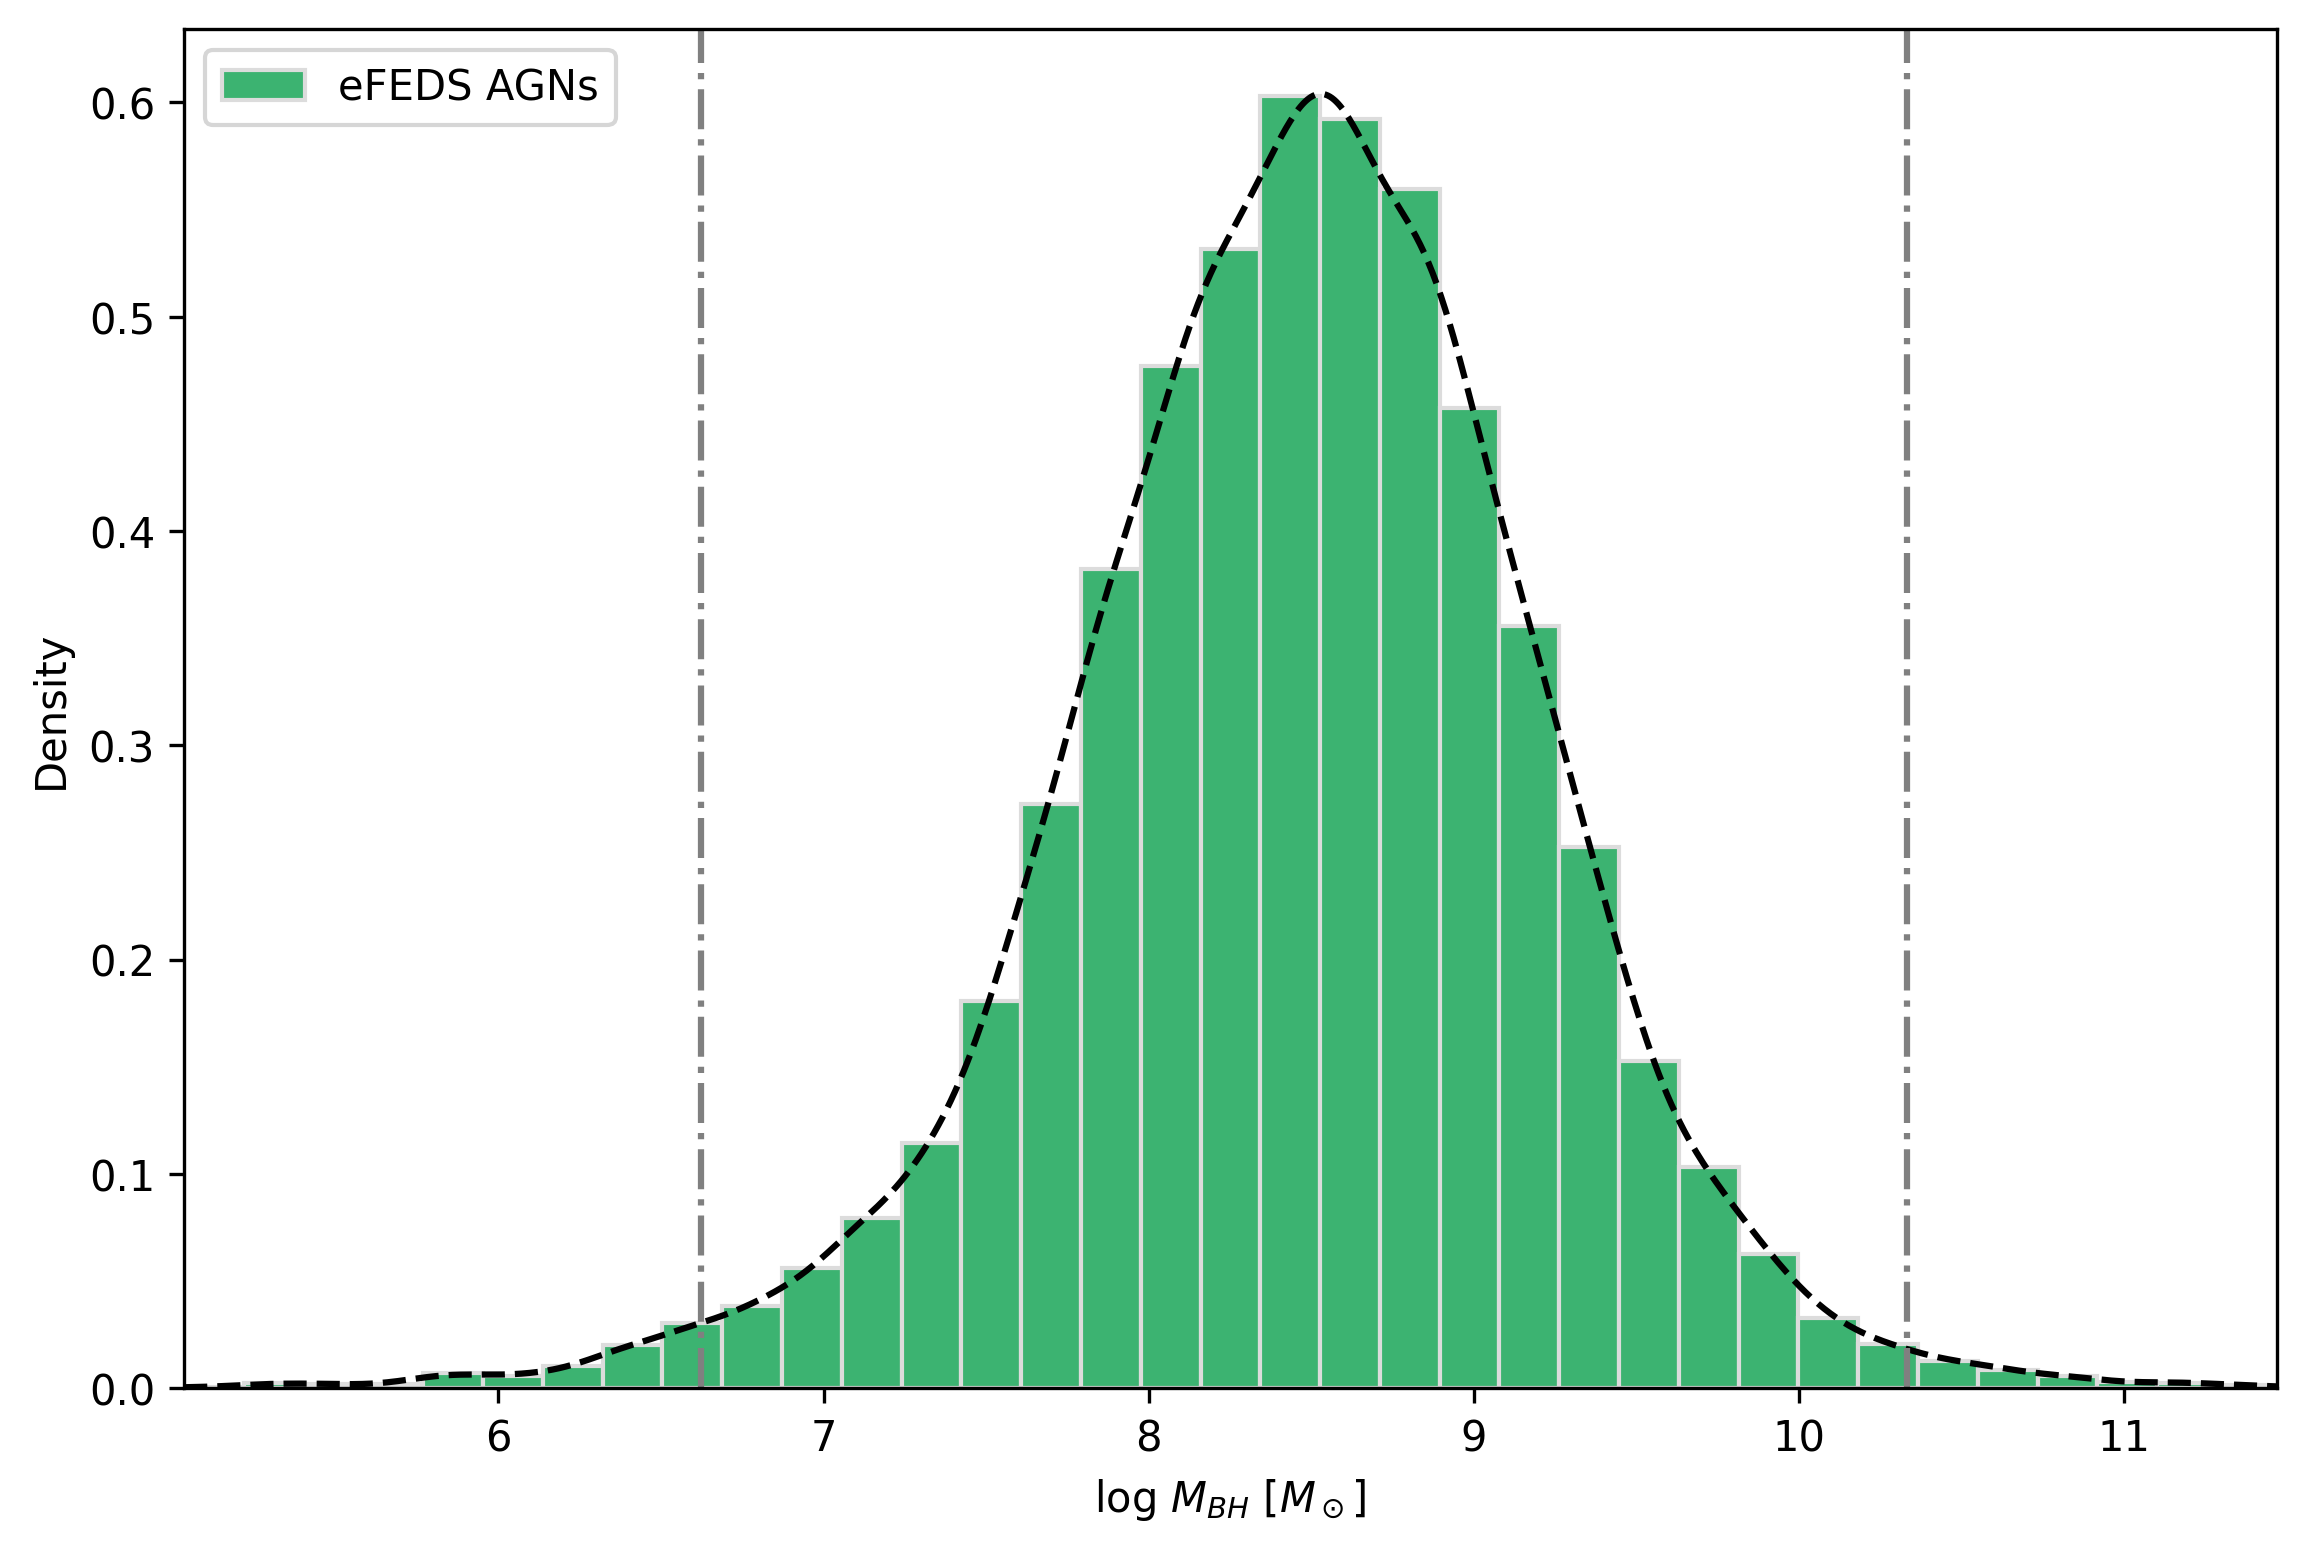

In [37]:
nvalue=[]
for i in range(len(mbh_new)):
    a = mbh_new[i].nominal_value
    nvalue.append(a)

kde = stats.gaussian_kde(nvalue)
xx = np.linspace(min(nvalue), max(nvalue), 1000)
ci = stats.norm(*stats.norm.fit(nvalue)).interval(0.99)

plt.figure(figsize=(9,6), dpi=300)
plt.plot(xx, kde(xx), color='black', linestyle='--')
plt.hist(nvalue,
    bins=35,
    density=True,
    color='mediumseagreen',
    edgecolor='gainsboro',
    label='eFEDS AGNs'
    )
plt.axvline(ci[0], color='grey', linestyle='-.')
plt.axvline(ci[1], color='grey', linestyle='-.')
plt.xlabel(r'log $M_{BH}$ [$M_\odot$]')
plt.ylabel('Density')
plt.margins(x=0)
plt.legend()

The distribution of estimated masses with the relation is well distributed in the SMBH mass regime, with the 99\% confidence interval in agreement with theoretical limits (up limit) and IMBH regime (bottom limit)

In [38]:
to_append = ['eFEDS_ID','eFEDS_Name','RA','DEC','Lx_soft','Lx_err','Mbh','Mbh_err']
estimation_sample = np.empty((0,len(to_append)), str)             #array to append important values after crossmatch with ether
for i in range (len(mbh_new)):
    efedsid = agn_filter['ID_SRC'][i]
    efedsname = agn_filter['Name'][i]
    ra_hb = agn_filter['RA_CORR'][i]
    dec_hb = agn_filter['DEC_CORR'][i]
    lum_mea = lum_and_err[i].nominal_value
    lum_std = lum_and_err[i].std_dev
    mbh_est = mbh_new[i].nominal_value
    mbh_std = mbh_new[i].std_dev

    estimation_sample = np.append(estimation_sample, np.array([[efedsid,efedsname,ra_hb,dec_hb,lum_mea,lum_std,mbh_est,mbh_std]]), axis=0)     #Save the info of the match source into the array

df_est = pd.DataFrame(estimation_sample, columns=to_append)
df_est

eFEDS_ID              eFEDS_Name                  RA  \
0            1  eFEDS J093700.9+010545  144.25383285520846   
1            3  eFEDS J085617.8-013805  134.07417045497337   
2            4  eFEDS J084025.4+033302  130.10609617356337   
3            7  eFEDS J091702.3-004415  139.25958886351057   
4            8  eFEDS J091400.3+050651   138.5016280856247   
...        ...                     ...                 ...   
12827    32642  eFEDS J093245.7-012437  143.19047123475852   
12828    32646  eFEDS J084053.3+003050  130.22232566495484   
12829    32662  eFEDS J085413.9-004053  133.55798840328177   
12830    32668  eFEDS J084150.6-012942  130.46095058138334   
12831    32681  eFEDS J085654.2+011311  134.22592849454372   

                       DEC             Lx_soft                 Lx_err  \
0       1.0959204090623735   43.50090026855469   0.005901336669921875   
1      -1.6347450374969688  43.325801849365234  0.0068492889404296875   
2       3.5508089298077246   43.30889892578125  0.0072498321533203125   
3      -0.7375046618167612   44.63650131225586   0.009550094604492188   
4        5.114247548661804  45.979400634765625    0.09980010986328125   
...                    ...                 ...                    ...   
12827  -1.4104821661578593   44.97090148925781      1.192352294921875   
12828   0.5141307982916261  45.577701568603516     0.8401508331298828   
12829  -0.6815208850968075   43.30400085449219      1.378000259399414   
12830   -1.495222838764824  45.597198486328125     2.2540969848632812   
12831   1.2199890078754794   43.14339828491211     1.3099002838134766   

                     Mbh             Mbh_err  
0      8.028487201608868  1.4385398298228405  
1       7.90390636191497  1.4357011060453544  
2      7.891880094498497  1.4354281731936875  
3       8.83645641250439  1.4571138645932173  
4      9.791916353245576  1.4810578733034332  
...                  ...                 ...  
12827  9.074378919386735  1.6908343923935891  
12828  9.506111334568722  1.5893563883337805  
12829  7.888395163926898   1.738231934048594  
12830  9.519983203845541   2.177559444568863  
12831   7.77412798168789   1.709190567672765  

[12832 rows x 8 columns]

The errors in the estimations are quite large (since these are in log), so its clear the necessity of more data to have a better fit

In [39]:
Mbh_err = df_est['Mbh_err'].astype(float)
print(Mbh_err.mean(), Mbh_err.max(), Mbh_err.min())

1.5088054138693767 3.5356255935306264 1.3837459063538227


The mean and min value are pretty close in comparison with the max value, so the distribution of errors is concentrated more close to the min value

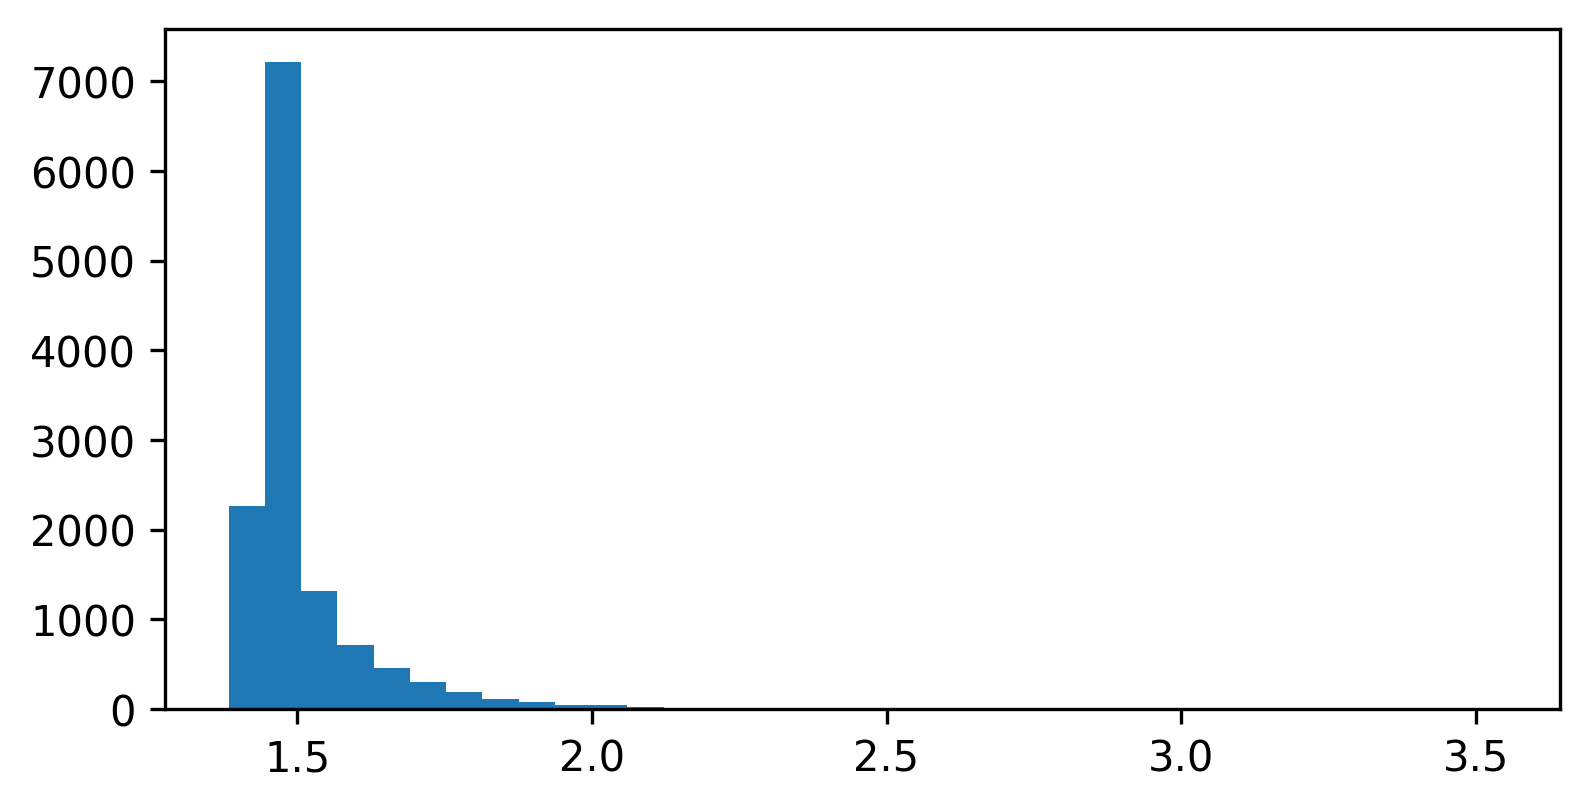

In [40]:
plt.figure(figsize=(6,3), dpi=300)
Mbh_err.hist(bins=35)
plt.grid(False)

eRASS should improve the statistics in this analyses with more data to use, so this is a 'good' start

# Fundamental Plane (FP) of BH accretion in ETHER data? 

In [41]:
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

def func(data, m, o): 
    return m * data[:,0] + o * data[:, 1]

#INPUT: FLUX (ergs/cm²/s), DIST (Mpc)
def flux_to_lum_xray(flux, dist):
    dist_64 = dist.astype(np.float64)   #float64 for bigger numbers on array
    flux_64 = flux.astype(np.float64)

    dist = dist_64*3.086e24         #Mpc to cm

    lum = 4*np.pi*(dist**2)*flux

    return lum              #returns luminosity on erg/s

#INPUT: FLUX (mJy), DIST (Mpc), NU (GHz)
def flux_to_lum_radio(flux, dist, nu=None, radio=False): 
    dist_64 = dist.astype(np.float64)   #float64 for bigger numbers on array
    flux_64 = flux.astype(np.float64)

    flux = flux_64/1000         #mJy to J
    dist = dist_64*3.086e24     #Mpc to cm
    if radio:
        nu = nu*1e9             #GHz to Hz
        lum = 4*np.pi*(dist**2)*flux*nu*1e-23
        return lum              #returns luminosity on erg/s
    else:
        lum = 4*np.pi*(dist**2)*flux*1e-23
        return lum              #returns luminosity on ergs/(s Hz)

In [43]:
agn_cat = fits.open('../ETHER/ETHER.fits')
data = agn_cat[1].data

ghz = [5, 8, 15, 23, 43, 86, 230]
freq = ghz[1]

(6.0372205, 10.60206)

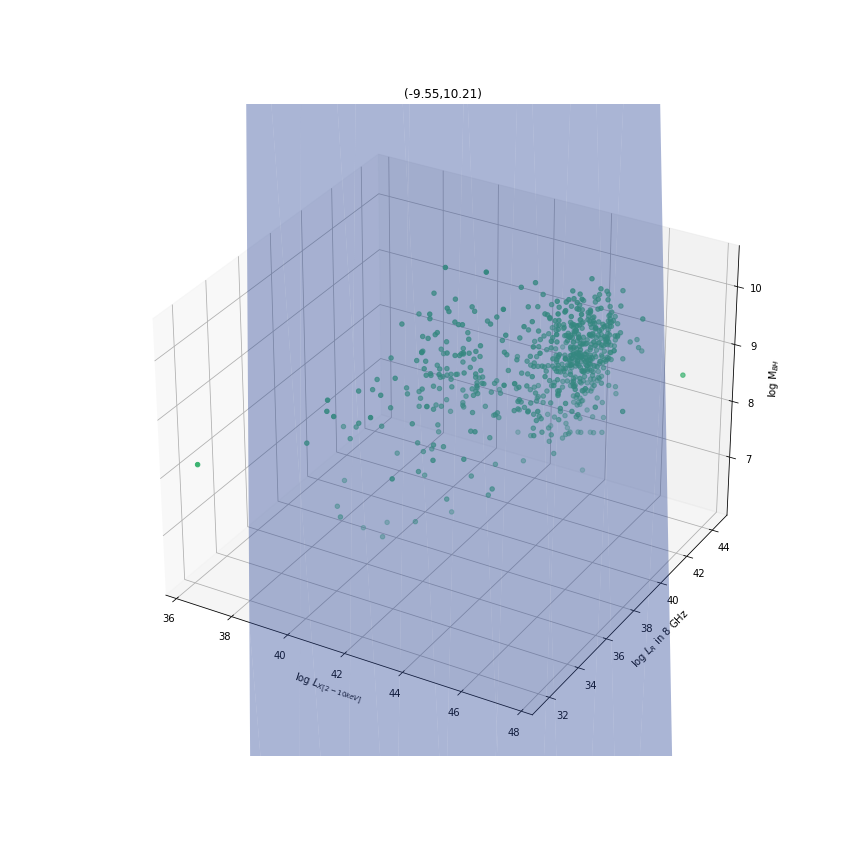

In [46]:
%matplotlib widget
dist = data['DIST']                         #distance
flux_radio = data['FLUX{}'.format(freq)]    #radio flux at desire GHz
flux_x = data['FLUXXRAY']                   #hardband Xray flux
est_mbh = data['MBH']                       #MBH previous estimation
mbh_method = data['MBHSOURCE']              #Prev. measurement/estimation method

no_data = 9876543                           #no data value

cond = (dist==no_data)|(flux_radio==no_data)|(flux_x==no_data)|(est_mbh==no_data)|(mbh_method==no_data)

dist_msk = np.delete(dist, cond)
flux_radio_msk = np.delete(flux_radio, cond)
flux_x_msk = np.delete(flux_x, cond)
est_mbh_msk = np.delete(est_mbh, cond)
mbh_mth_msk = np.delete(mbh_method, cond)

lum_5 = flux_to_lum_radio(flux_radio_msk, dist_msk, nu=freq, radio=True)
lum_x = flux_to_lum_xray(flux_x_msk, dist_msk)

log_lx = np.log10(lum_x)
log_lr = np.log10(lum_5)

log_lx = np.delete(log_lx, np.where(np.isnan(log_lr)))
est_mbh_msk = np.delete(est_mbh_msk, np.where(np.isnan(log_lr)))
log_lr = np.delete(log_lr, np.where(np.isnan(log_lr)))

all_data = np.array(list(zip(log_lx, log_lr, est_mbh_msk)))
guess = (1, 1)
params, pcov = curve_fit(func, all_data[:, ::2], all_data[:,1], guess)

x = np.linspace(min(log_lx), max(log_lx), 10)
y = np.linspace(min(log_lr), max(log_lr), 10)
X, Y = np.meshgrid(x, y)
Z = -params[0] / params[1] * X + 1 / params[1] * Y

fig1 = plt.figure(1, figsize=(12,12))
ax = fig1.add_subplot( 1, 1, 1, projection='3d')
ax.scatter(log_lx, log_lr, est_mbh_msk, color='mediumseagreen')
ax.plot_surface(X, Y, Z, color='royalblue', alpha=0.4)
ax.set_title('({:1.2f},{:1.2f})'.format(-params[0] / params[1], 1 / params[1]))
ax.set_xlabel(r'log $L_{X[2-10 keV]}$')
ax.set_ylabel(r'log $L_{R}$' + ' in {} GHz'.format(freq))
ax.set_zlabel(r'log M$_{BH}$')
ax.set_zlim(min(est_mbh_msk), max(est_mbh_msk))

# Pesce's ADAF model analysis in search of FP of BH accretion

Pesce's spectral energy distributions (SEDs) for ADAF modelling (Pesce et al. 2021) brings the possibility to test the origing of the FP. Is it really the ADAF that produce the emission that we used in the FP to estimate BH mass? Gültekin et al. (2019) made use of VLA Radio data to fit the plane in the Mbh-5GHz-Xray space, deriving a FP estimator that can be used for any AGN with Radio and Xray data available.

Fischer et al. (2021) found that VLBA data jump off the FP, arguing that the VLA data may be contaminated with other source of emission (gas?) outside the AGN, so FP is not originated only by ADAF emission.

Here I produce data with Pesce's ADAF model to test the FP.

In [48]:
from SEDmodel import SED

In [49]:
nu = 10.0**np.linspace(np.log10(1.E8),np.log10(1.8E18),1000)   # EHT to Chandra 
freq_r = [5e9, 8e9, 15e9, 23e9, 43e9, 86e9, 230e9] #0 6
freq_x = [3.627e17, 1.45e18] #0 1

mvec    = 10**np.linspace(6,11,25)	
mdotvec = 10**np.linspace(-7,-1.8,25)

# Output lists
outm=['Mbh']
outmdot=['dot_Mbh']
outl5=['5GHz']
outl8=['8GHz']
outl15=['15GHz']
outl23=['23GHz']
outl43=['43GHz']
outl86=['86GHz']
outl230=['230GHz']
outlx_soft=['Lx_soft']
outlx_hard=['Lx_hard']

With all the lists ready, the idea is to iteratvely run the code for different Mbh (m) and accretion rates (mdot) and save the values of luminosity (nu*L_nu) for the respective frequency (in freq_r and freq_x).

The next cell is the code used to produce the data, but it's not recommended to run the cell, since it takes some time (in my case, roughly 20 min)

In [ ]:
# DO NOT RUN THIS CELL, 20 MIN APPROX TO RUN

for m in mvec:
   for mdot in mdotvec:
        print('m,mdot =',m,'  ',mdot)
        # Calculate ADAF model 
        Lnu_j, _ = SED(nu, m, mdot)

        df   = abs(nu - freq_r[0])    # Array of differences between the total frequency range and the actual frequency.
        df_i = np.where(df == min(df))[0][0]  # Store the index of the frequency closest to that of the data.
        outl5.append(nu[df_i]*Lnu_j[df_i])

        df   = abs(nu - freq_r[1])    # Array of differences between the total frequency range and the actual frequency.
        df_i = np.where(df == min(df))[0][0]  # Store the index of the frequency closest to that of the data.
        outl8.append(nu[df_i]*Lnu_j[df_i])

        df   = abs(nu - freq_r[2])    # Array of differences between the total frequency range and the actual frequency.
        df_i = np.where(df == min(df))[0][0]  # Store the index of the frequency closest to that of the data.
        outl15.append(nu[df_i]*Lnu_j[df_i])

        df   = abs(nu - freq_r[3])    # Array of differences between the total frequency range and the actual frequency.
        df_i = np.where(df == min(df))[0][0]  # Store the index of the frequency closest to that of the data.
        outl23.append(nu[df_i]*Lnu_j[df_i])

        df   = abs(nu - freq_r[4])    # Array of differences between the total frequency range and the actual frequency.
        df_i = np.where(df == min(df))[0][0]  # Store the index of the frequency closest to that of the data.
        outl43.append(nu[df_i]*Lnu_j[df_i])

        df   = abs(nu - freq_r[5])    # Array of differences between the total frequency range and the actual frequency.
        df_i = np.where(df == min(df))[0][0]  # Store the index of the frequency closest to that of the data.
        outl86.append(nu[df_i]*Lnu_j[df_i])

        df   = abs(nu - freq_r[6])    # Array of differences between the total frequency range and the actual frequency.
        df_i = np.where(df == min(df))[0][0]  # Store the index of the frequency closest to that of the data.
        outl230.append(nu[df_i]*Lnu_j[df_i])
        #print('outl230 =',outl230)
        df   = abs(nu - freq_x[0])    # Array of differences between the total frequency range and the actual frequency.
        df_i = np.where(df == min(df))[0][0]  # Store the index of the frequency closest to that of the data.
        outlx_soft.append(nu[df_i]*Lnu_j[df_i])

        df   = abs(nu - freq_x[1])    # Array of differences between the total frequency range and the actual frequency.
        df_i = np.where(df == min(df))[0][0]  # Store the index of the frequency closest to that of the data.
        outlx_hard.append(nu[df_i]*Lnu_j[df_i])
        #print('outlx =',outlx)
        outm.append(m)
        outmdot.append(mdot)

final_sample = np.column_stack((outm,outmdot,outl5,outl8,outl15,outl23,outl43,outl86,outl230,outlx_soft,outlx_hard))

The original script save the data to a csv file, so here I open it to continue with the analysis

In [50]:
df_pesce = pd.read_csv('../Scripts/Pesce ADAF/out.csv')
df_pesce

Mbh       dot_Mbh          5GHz          8GHz         15GHz  \
0    1.000000e+06  1.000000e-07  3.190157e+30  8.265138e+30  2.988074e+31   
1    1.000000e+06  1.646898e-07  4.167938e+30  1.079398e+31  3.900164e+31   
2    1.000000e+06  2.712273e-07  5.559944e+30  1.443686e+31  5.234986e+31   
3    1.000000e+06  4.466836e-07  7.243811e+30  1.880098e+31  6.813470e+31   
4    1.000000e+06  7.356423e-07  9.222464e+30  2.383332e+31  8.586972e+31   
..            ...           ...           ...           ...           ...   
620  1.000000e+11  2.154435e-03  9.315017e+39  2.020838e+40  5.749119e+40   
621  1.000000e+11  3.548134e-03  1.027039e+40  2.149412e+40  5.825182e+40   
622  1.000000e+11  5.843414e-03  1.045816e+40  2.070216e+40  5.204422e+40   
623  1.000000e+11  9.623506e-03  9.707220e+39  1.772066e+40  3.993472e+40   
624  1.000000e+11  1.584893e-02  5.818968e+39  8.923592e+39  1.589385e+40   

            23GHz         43GHz         86GHz        230GHz       Lx_soft  \
0    7.038588e+31  2.544643e+32  1.011840e+33  7.123744e+33  8.450238e+30   
1    9.183689e+31  3.318322e+32  1.318700e+33  9.275331e+33  4.542580e+31   
2    1.235599e+32  4.480438e+32  1.787325e+33  1.263945e+34  3.366189e+32   
3    1.607535e+32  5.825702e+32  2.322510e+33  1.640948e+34  1.703807e+33   
4    2.018105e+32  7.271087e+32  2.880638e+33  2.017346e+34  6.049677e+33   
..            ...           ...           ...           ...           ...   
620  1.154289e+41  3.283857e+41  1.009459e+42  4.193733e+42  6.867846e+44   
621  1.132321e+41  3.068735e+41  8.954118e+41  3.574842e+42  1.898595e+45   
622  9.622267e+40  2.418995e+41  6.511020e+41  1.877871e+42  3.780509e+45   
623  6.864335e+40  1.546932e+41  3.702999e+41  8.351357e+41  8.625738e+45   
624  2.335377e+40  4.159605e+40  1.048962e+41  1.709319e+41  2.733924e+46   

          Lx_hard  
0    3.775932e+30  
1    2.163926e+31  
2    1.756230e+32  
3    9.511524e+32  
4    3.535003e+33  
..            ...  
620  1.132772e+45  
621  3.510966e+45  
622  7.861976e+45  
623  2.105531e+46  
624  8.811278e+46  

[625 rows x 11 columns]

In [51]:
freq_r = '8GHz'
freq_x = 'Lx_hard'

log_mbh = np.log10(df_pesce['Mbh'])
log_lx = np.log10(df_pesce[freq_x])
log_lr = np.log10(df_pesce[freq_r])

all_data = np.array(list(zip(log_lx, log_lr, log_mbh)))
guess = (1, 1)
params, pcov = curve_fit(func, all_data[:, ::2], all_data[:,1], guess)

x = np.linspace(min(log_lx), max(log_lx), 10)
y = np.linspace(min(log_lr), max(log_lr), 10)
X, Y = np.meshgrid(x, y)
Z = -params[0] / params[1] * X + 1 / params[1] * Y

(6.0, 11.0)

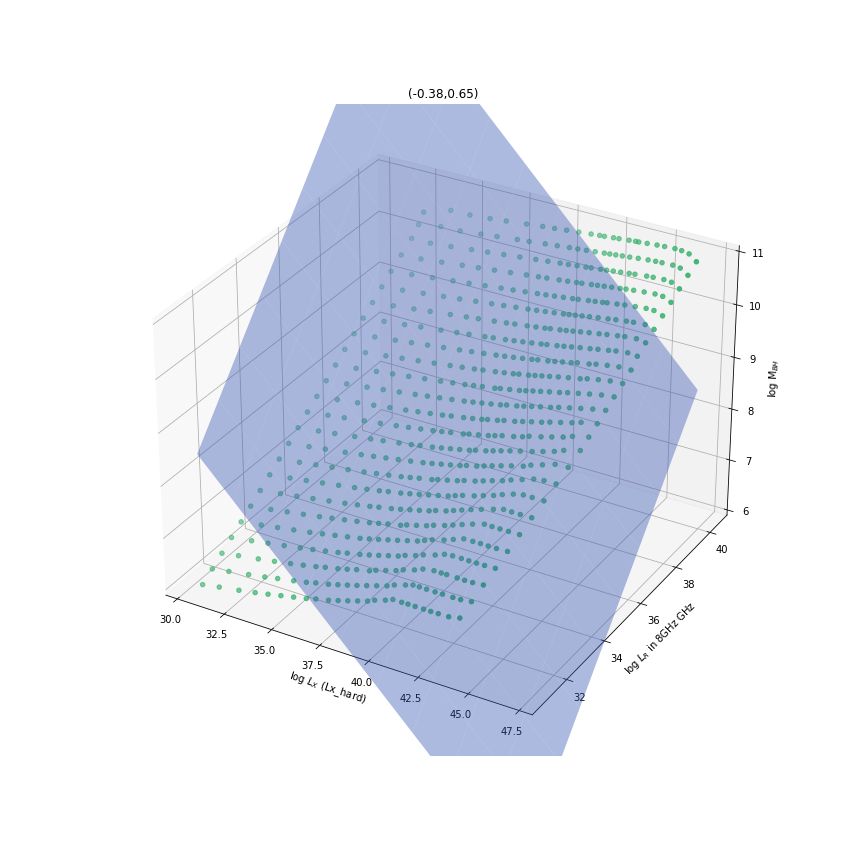

In [52]:
%matplotlib widget
fig1 = plt.figure(1, figsize=(12,12))
ax = fig1.add_subplot( 1, 1, 1, projection='3d')
ax.scatter(log_lx, log_lr, log_mbh, color='mediumseagreen')
ax.plot_surface(X, Y, Z, color='royalblue', alpha=0.4)
ax.set_title('({:1.2f},{:1.2f})'.format(-params[0] / params[1], 1 / params[1]))
ax.set_xlabel(r'log $L_{X}$' + ' ({})'.format(freq_x))
ax.set_ylabel(r'log $L_{R}$' + ' in {} GHz'.format(freq_r))
ax.set_zlabel(r'log M$_{BH}$')
# ax.set_xlim(min(l_x), max(l_x))
# ax.set_ylim(min(l_r), max(l_r))
ax.set_zlim(min(log_mbh), max(log_mbh))